# DEEP LEARNING ASSIGNMENT 1

#### Priya Savithiri Baskaran (25232590)

# TASK 1

- Purpose: set up NumPy and a small show() helper to inspect shapes/values during development.
- Why it matters: In neural nets, most bugs come from shape mismatch. Printing the shapes early avoids silent errors!!

Ref: 
- [Flattening Arrays](https://www.w3schools.com/python/numpy/numpy_array_reshape.asp#:~:text=Flattening%20the%20arrays)
- [Datatype Conversion](https://www.w3schools.com/python/numpy/numpy_data_types.asp#:~:text=Change%20data%20type%20from%20float%20to%20integer%20by%20using%20int%20as%20parameter%20value%3A)

In [108]:
import numpy as np
np.random.seed(0)

def show(name, arr, max_items=5):
    arr = np.array(arr)
    print(f"{name}: shape={arr.shape}, first={arr.reshape(-1)[:max_items]}")

def to_col(x):
    """
    To cnvert feature vector x into col vector of shape (n,1), it accepts x shapes as ----> (n,), (n,1), (1,n)
    """
    x = np.array(x, dtype=float)
    if x.ndim == 1:
        return x.reshape(-1, 1)
    if x.ndim == 2:
        if x.shape[1] == 1:      # (n,1)
            return x
        if x.shape[0] == 1:      # (1,n)
            return x.reshape(-1, 1)
    raise ValueError(f"to_col: ### EXPECTED (n,), (n,1), or (1,n). Got {x.shape}")

def to_1d_labels(y):
    """
    To convrt labels into shape (m,) that has values 0/1, it accepts y as ----> (m,), (m,1), (1,m)
    """
    y = np.array(y)
    if y.ndim == 0:
        return y.reshape(1).astype(int)
    if y.ndim == 1:
        return y.astype(int)
    if y.ndim == 2:
        return y.reshape(-1).astype(int)
    raise ValueError(f"to_1d_labels: unexpected shape {y.shape}")

### Activation Function

The sigmoid activation:

sig(z)= 1 / 1+ e ^ −z

Why it matters?

-> LR outputs a prob for binary classification,
-> Sigmoid maps the linear score z to a number between 0 and 1,
-> Quick tests like: sig(0)=0.5 help verify correctness.

Reference: [Usage of sigmoid](https://medium.com/data-science/lets-code-a-neural-network-in-plain-numpy-ae7e74410795#:~:text=in%20the%20algorithm.-,Activation%20functions,-A)

In [109]:
# Squeezeesss any num into 0 to 1

# If z is large positive ---> sigmoid is near 1
# If z is large negative ---> sigmoid is near 0
# If z = 0 ---> sigmoid is 0

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

print("sigmoid(0):",sigmoid(0))
print("sigmoid(5):",sigmoid(5))
print("sigmoid(-5):",sigmoid(-5))


sigmoid(0): 0.5
sigmoid(5): 0.9933071490757153
sigmoid(-5): 0.0066928509242848554


## Forward pass

A) Single sample forward

- Input: one sample x with n features
- Computation: z = w (Transpose) * x + b and y' = sig(z)
- Output: scalar z and scalar y	​


B) Multi-sample forward

- Input: dataset x with m samples and n features
- Computation: z = w * x + b and y' = sig(z)
- Output: vectors z -> R ^ m*1 and y -> R ^ m*1

1. -> Both are exactly the same model, the transpose just makes the dot product dims right.
2. -> SGD trains on 1 random sample @ a time, so we need the single sample forward,
3. -> For evaluation and later tasks, it’s convenient to compute predictions for all samples at once, so my fxn also support multi sample forward.

Ref:
- [Blog on Logistic Regression from Scratch](https://www.geeksforgeeks.org/machine-learning/implementation-of-logistic-regression-from-scratch-using-python/)

In [110]:
def forward(x, w, b, debug=False):
    """
    I've written a little flexible frwd pass;
     => if x is 1 sample: (n,) or (n,1) or (1,n) ---> returns scalar y_hat and scalar z
     => if x is multiple samples: (m,n) -> returns (m,1) y_hat and (m,1) z
    """
    w = to_col(w)  # juz to ensure (n,1)

    A = np.array(x, dtype=float)

    # Case 1: single sample
    if A.ndim == 1 or (A.ndim == 2 and (A.shape[0] == 1 or A.shape[1] == 1) and A.size == w.size):
        x = to_col(A)  # (n,1)
        z_mul = np.dot(w.T, x) + b  # (1,1)
        z = float(z_mul)
        y_prob = float(sigmoid(z))

        if debug:
            print("---- forward (single) ----")
            show("x", x)
            show("w", w)
            print("b:", b)
            print("z:", z)
            print("y_prob:", y_prob)
            print("--------------------------")

        return z, y_prob

    # Case 2: multiple samples
    if A.ndim == 2:
        X = A  # (m,n)
        if X.shape[1] != w.shape[0]:
            raise ValueError(f"OOPSS!!! forward: X has {X.shape[1]} features but w has {w.shape[0]} weights :(")

        z = np.dot(X, w) + b         # (m,1)
        y_prob = sigmoid(z)           # (m,1)

        if debug:
            print("---- forward (many) ----")
            show("X", X)
            show("w", w)
            print("b:", b)
            show("z", z)
            show("y_prob", y_prob)
            print("------------------------")

        return z, y_prob

    raise ValueError(f"forward: unexpected input shape {A.shape}")


## Loss Function

A) Single sample loss

- For one sample: J = - [y log (y') + (1 - y) log (1-y')]​

B) Multi-sample average loss

- For m samples:  J = - 1/m * Summation(i=1 to m) [y^i log (y'^i) + (1 - y^i) log (1-y'^i)]​

Tiny epsilon (clipping):
- In floating-point arithmetic, y' can become numerically 0 / 1 for extreme values of z causing log(0) which is undefined.
- Clipping ensures y' -> [eps,1−eps] so the loss remains finite.
- risk getting inf/nan if weights get large or learning rate is high.
- This is just a numerical safeguard, it doesn't change the core algorithm.

Sanity checks:

- If prediction matches label well -> loss small
- If prediction is confidently wrong -> loss large

Ref:
- [Log loss for Binary Classification](https://www.geeksforgeeks.org/deep-learning/binary-cross-entropy-log-loss-for-binary-classification/)
- [Clipping in log-loss](https://github.com/xbeat/Machine-Learning/blob/main/Explaining%20Log%20Loss%20Using%20Python.md)

In [111]:
def bin_ce_loss(y, y_prob, eps=1e-12, debug=False):
    """
    binary cross entropy loss:
     => if y_prob is scalar -> returns scalar loss
     => if y_prob is (m,1) -> returns avg loss over m
    """
    y = to_1d_labels(y)

    if np.isscalar(y_prob):
        yh = float(min(max(y_prob, eps), 1 - eps))
        yy = int(y[0])
        J = -(yy * np.log(yh) + (1 - yy) * np.log(1 - yh))
        if debug:
            print("loss fxn(single):", float(J))
        return float(J)

    y_prob = np.array(y_prob, dtype=float).reshape(-1)  # (m,)
    y_prob = np.clip(y_prob, eps, 1 - eps)

    if y_prob.shape[0] != y.shape[0]:
        raise ValueError(f"bin_ce_loss: y has {y.shape[0]} items but y_prob has {y_prob.shape[0]} items")

    m = y.shape[0]
    J = -(1.0 / m) * np.sum(y * np.log(y_prob) + (1 - y) * np.log(1 - y_prob))

    if debug:
        print("loss (many):", float(J))

    return float(J)


## Gradients for one sample (partial derivatives)

- Goal: Compute gradients for one training example (SGD).

- Key idea: For logistic regression + log loss + sigmoid, the error term simplifies nicely: For a single training example, it gives the partial derivatives:
    - der(w) = (y'-y)*x, der(b) = (y'-y)

- Sanity checks:
    - If y' > y for a negative example, gradient pushes weights down.
    - Gradients match weight dimensions.


Why?:
- SGD updates parameters using one sample’s gradient at a time.
- learning signal: if the prediction is too high/low compared to y, the error term (y'-y)tells us how to adjust w and b.

In [112]:
def gradients_one(x, y, y_prob, debug=False):
    x = to_col(x)        # (n,1)
    y = to_1d_labels(y)  # (1,)
    y = int(y[0])
    y_prob = float(y_prob)

    err = (y_prob - y)    # scalar
    dw = err * x         # (n,1)
    db = err             # scalar

    if debug:
        print("---- gradients_one ----")
        print("error (y_prob - y):", err)
        show("dw", dw)
        print("db:", float(db))
        print("-----------------------")

    return dw, db

## Training loop (SGD + stopping)

What the algorithm does?

- Initialize w and b (e.g., zeros)
- Repeat:
    - Pick a random index i 
    - Take training pair (x(i),y(i))
    - Forward pass: compute y'(i)
- Compute loss J(i)
- Compute gradients der(w), der(b)
- Update:
    - w -> w - alpha * der(w),  b-> b - alpha * der(b)
- Accumulate running cost over N iterations:
    - J running := Summation(k=1 to N) J^k
- Every N steps, compare to previous running cost and stop when:
    - | J running - J running-prev| < threshold


- Stopping logic in my code:

    - Tracking “running loss” every N steps, Stop if improvement becomes tiny (threshold) Or stop at max_iterations

- Sanity checks:
    - Loss trend generally decreases over time
    - Accuracy should improve on simple data

Ref:
- [GD vs SGD](https://medium.com/analytics-vidhya/gradient-descent-vs-stochastic-gd-vs-mini-batch-sgd-fbd3a2cb4ba4)
- [GD from Scratch using numpy](https://medium.com/@yatshunlee/gradient-descent-from-scratch-using-numpy-only-linear-regression-and-quantile-regression-examples-fcb8763d766d)
- [SGD](https://realpython.com/gradient-descent-algorithm-python/)
- [SGD from Scratch](https://medium.com/biased-algorithms/stochastic-gradient-descent-from-scratch-in-python-81a1a71615cb)

In [113]:
def fit_logreg_sgd(X, y, alpha=0.1, max_iterations=20000, threshold=1e-4, N=None, debug_every_N=True):
    X = np.array(X, dtype=float)
    if X.ndim != 2:
        raise ValueError("fit_logreg_sgd: X must be shape (m,n)")

    y = to_1d_labels(y)  # (m,)
    m, n = X.shape
    if y.shape[0] != m:
        raise ValueError(f"fit_logreg_sgd: X has {m} rows but y has {y.shape[0]} labels")

    if N is None:
        N = m

    w = np.zeros((n, 1))
    b = 0.0

    stopping = False
    J_running = 0.0
    J_running_prev = 0.0
    iteration = 0

    rng = np.random.default_rng(0)
    history_batches = []

    while not stopping:
        i = rng.integers(0, m)
        x_i = X[i]              # (n,)
        y_i = y[i]              # scalar 0/1

        _, y_hat = forward(x_i, w, b)          # single-sample forward
        J_current = bin_ce_loss(y_i, y_hat)       # single-sample loss
        dw, db = gradients_one(x_i, y_i, y_hat)

        w = w - alpha * dw
        b = b - alpha * db

        iteration += 1
        J_running += J_current

        if iteration > max_iterations:
            stopping = True
            print("Stopped: reached max_iterations.")

        if (iteration % N) == 0:
            change = abs(J_running - J_running_prev)
            history_batches.append((iteration, J_running, change))

            if debug_every_N:
                print(f"After {iteration} iterations: J_running={J_running:.4f}, change={change:.6f}")

            if change < threshold:
                stopping = True
                print("Stopped: convergence reached (change < threshold).")

            J_running_prev = J_running
            J_running = 0.0

    return w, b, history_batches


In [114]:
# helper fxn to produce probs from frwd pass for many samples.

def predict_prob(X, w, b):
    # uses many sample forward: z = Xw + b, y_hat = sigmoid(z)
    _, y_hat = forward(X, w, b)
    return y_hat  # (m,1)

def predict_class(X, w, b, threshold=0.5):
    y_hat = predict_prob(X, w, b).reshape(-1)
    return (y_hat >= threshold).astype(int)

def accuracy(y_true, y_pred):
    y_true = to_1d_labels(y_true)
    y_pred = to_1d_labels(y_pred)
    return (y_true == y_pred).mean()

- Goal: Create a small synthetic dataset to confirm training works end-to-end.

What to verify:

- Shapes print correctly
- Training reduces loss and improves accuracy

In [115]:
m = 200
X = np.random.randn(m, 2)
true_w = np.array([[2.0], [-3.0]])
true_b = 0.5

scores = np.dot(X, true_w) + true_b
y = (scores.reshape(-1) > 0).astype(int)

# Train
w, b, hist = fit_logreg_sgd(
    X, y,
    alpha=0.2,
    max_iterations=20000,
    threshold=1e-2,
    N=m,
    debug_every_N=True
)

# this fxn evaluates (many samples)
y_pred = predict_class(X, w, b)
acc = accuracy(y, y_pred)
print("Training accuracy (sanity check):", acc)

# also testing 1 sample frwd
x0 = X[0]  # shape (n,)
z0, yhat0 = forward(x0, w, b, debug=True)
pred_class = 1 if yhat0 >= 0.5 else 0
print("True:", y[0], "| Pred class:", pred_class, "| Pred prob:", yhat0)

After 200 iterations: J_running=58.0832, change=58.083177
After 400 iterations: J_running=36.2356, change=21.847566
After 600 iterations: J_running=29.5114, change=6.724164
After 800 iterations: J_running=18.2733, change=11.238116
After 1000 iterations: J_running=21.9854, change=3.712088
After 1200 iterations: J_running=20.9718, change=1.013607
After 1400 iterations: J_running=15.7000, change=5.271790
After 1600 iterations: J_running=18.8195, change=3.119483
After 1800 iterations: J_running=11.1583, change=7.661186
After 2000 iterations: J_running=13.7350, change=2.576666
After 2200 iterations: J_running=12.4646, change=1.270370
After 2400 iterations: J_running=14.6922, change=2.227566
After 2600 iterations: J_running=16.9795, change=2.287308
After 2800 iterations: J_running=13.5114, change=3.468114
After 3000 iterations: J_running=13.9144, change=0.403060
After 3200 iterations: J_running=13.4645, change=0.449899
After 3400 iterations: J_running=9.6952, change=3.769361
After 3600 itera

C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3127467275.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = float(z_mul)


After 7000 iterations: J_running=7.9180, change=0.925257
After 7200 iterations: J_running=6.6790, change=1.239000
After 7400 iterations: J_running=8.5686, change=1.889652
After 7600 iterations: J_running=7.3334, change=1.235225
After 7800 iterations: J_running=7.2234, change=0.109965
After 8000 iterations: J_running=9.1037, change=1.880256
After 8200 iterations: J_running=5.8375, change=3.266181
After 8400 iterations: J_running=6.1005, change=0.262993
After 8600 iterations: J_running=6.9731, change=0.872537
After 8800 iterations: J_running=6.5168, change=0.456271
After 9000 iterations: J_running=8.3827, change=1.865950
After 9200 iterations: J_running=8.1741, change=0.208651
After 9400 iterations: J_running=6.4696, change=1.704444
After 9600 iterations: J_running=8.4661, change=1.996418
After 9800 iterations: J_running=4.7733, change=3.692723
After 10000 iterations: J_running=9.3327, change=4.559410
After 10200 iterations: J_running=8.4713, change=0.861429
After 10400 iterations: J_run

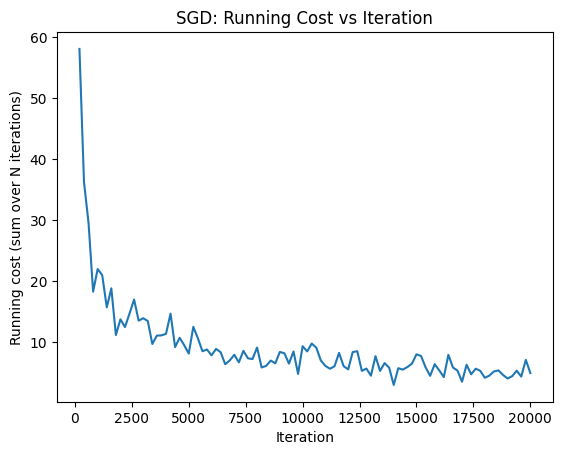

In [116]:
"""
Visual verification says:
- If loss decreases and then flattens -> convergence
- If accuracy increases -> model is learning
"""

import matplotlib.pyplot as plt

iters = [h[0] for h in hist]
Jrun  = [h[1] for h in hist]

plt.figure()
plt.plot(iters, Jrun)
plt.xlabel("Iteration")
plt.ylabel("Running cost (sum over N iterations)")
plt.title("SGD: Running Cost vs Iteration")
plt.show()

- At the start, the cost drops really fast. That’s a good sign, it means the model is learning the main pattern in the data quickly.
- After a while, the line starts going down more slowly and kind of levels off. That usually means the model is almost done learning and further updates are only making small improvements.
- You can also see the line is a bit bumpy instead of perfectly smooth. That’s normal for SGD, because I update the weights using one random training example at a time, so the cost can jump a little up and down.
- Overall, since the graph keeps trending downward, training is working properly and the model is improving over time.

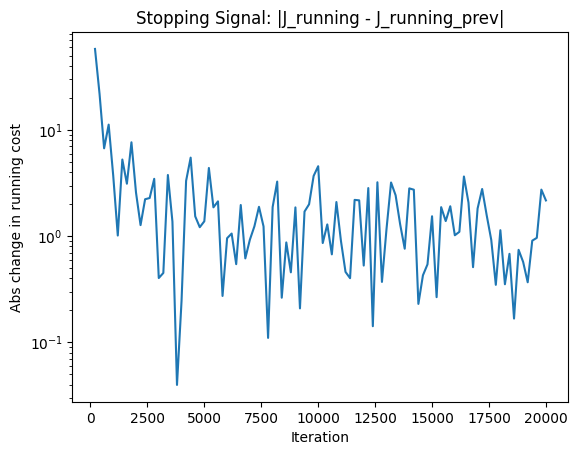

In [117]:
change = [h[2] for h in hist]

plt.figure()
plt.plot(iters, change)
plt.xlabel("Iteration")
plt.ylabel("Abs change in running cost")
plt.title("Stopping Signal: |J_running - J_running_prev|")
plt.yscale("log")  # optional, makes it easier to see shrinking values
plt.show()


This graph is showing how much the running cost changes from one checkpoint to the next:
- At the beginning, the change is very large which means the model is still learning a lot and the cost is improving quickly.
- After some iterations, the values drop and stay much smaller overall means the model is no longer making big improvements -> it’s starting to settle.
- The line still jumps up and down instead of smoothly shrinking to zero. That’s normal because I'm using SGD, so each update is based on a random training sample & things can be noisy.
- Even though it’s noisy, the important point is: compared to the start, the changes are generally smaller, which suggests the model is getting closer to convergence. If we set a small threshold, training would stop once these changes consistently fall below it.

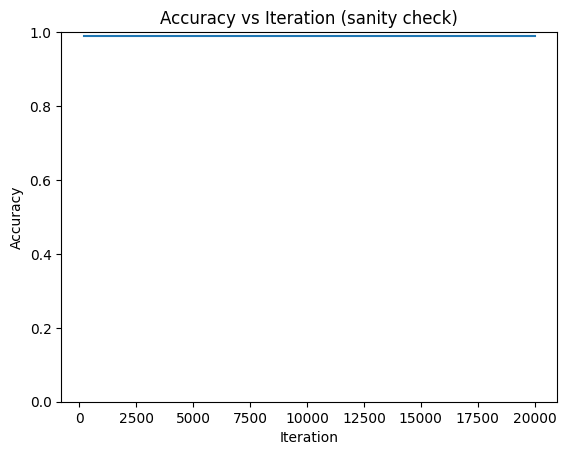

In [118]:
accs = []
for _iter, _, _ in hist:
    y_pred = predict_class(X, w, b)   # for sanity test you used same X
    accs.append(accuracy(y, y_pred))

plt.figure()
plt.plot(iters, accs)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iteration (sanity check)")
plt.ylim(0, 1)
plt.show()


# TASK 2

- Goal: Load blobs and circles datasets and visually inspect class separation.

- Inference:

    -  blobs looks (almost) linearly separable -> logistic regression should do well
    - circles is non-linear -> logistic regression will struggle

In [119]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import pandas as pd
import numpy as np

%matplotlib inline



### DATASET 1

In [120]:
# Use pandas to read the CSV file as a dataframe
df1 = pd.read_csv("blobs600.csv")

# The y values are those labelled 'Class': extract their values
y1 = df1['Class'].values

# The x values are all other columns
del df1['Class']   # drop the 'Class' column from the dataframe
X1 = df1.values     # convert the remaining columns to a numpy array

# Check its dimensions

print(f"The dimensions of the dataset are: {np.shape(X1)}")

The dimensions of the dataset are: (600, 3)


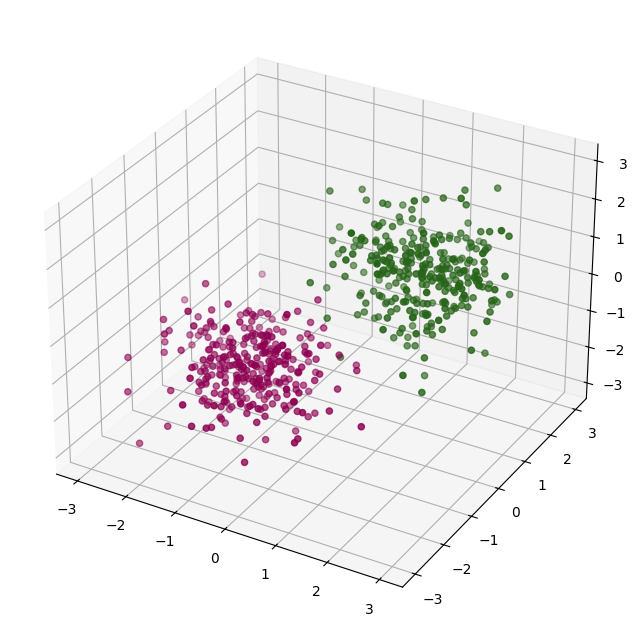

In [121]:
# Plot the dataset in 3D, with colours according to the class label

fig = plt.figure(figsize=(8, 8)) # set the size to 8x8 
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X1[:,0], X1[:,1], X1[:,2], c=y1, cmap="PiYG") # changed the colour map because why not

plt.show()
plt.close(fig)

### DATASET 2

In [122]:
# Use pandas to read the CSV file as a dataframe
df2 = pd.read_csv("circles500.csv")

# The y values are those labelled 'Class': extract their values
y2 = df2['Class'].values

# The x values are all other columns
del df2['Class']   # drop the 'Class' column from the dataframe
X2 = df2.values     # convert the remaining columns to a numpy array

In [123]:
print(f"The dimensions of Dataset 2 are: {np.shape(X2)}")

The dimensions of Dataset 2 are: (500, 2)


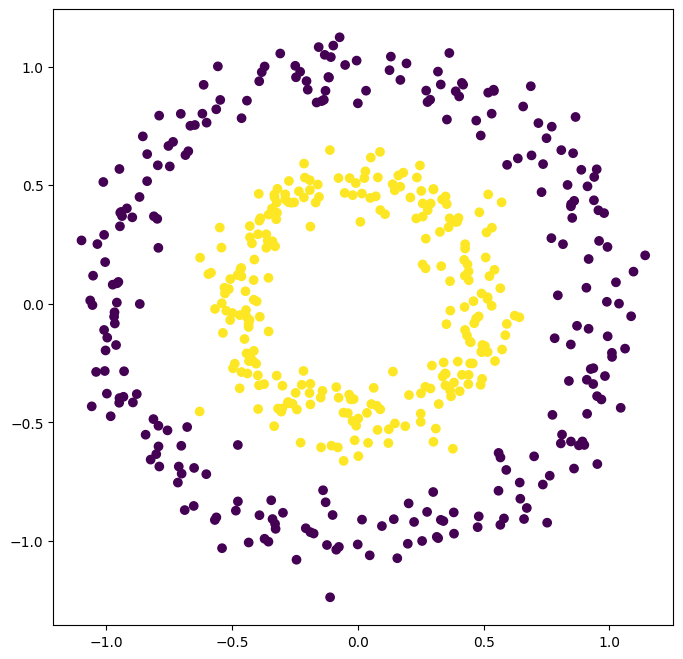

In [124]:
# plot X[0] vs X[1] and colour points according to the class, y

fig, ax = plt.subplots(figsize=(8, 8)) 

ax.scatter(X2[:,0], X2[:,1], c=y2) 

plt.show()
plt.close(fig)

In [125]:
# Some examples of working with the data, to look at rows/columns
print ("len(X2):", len(X2))            # outer array: one per sample
print ("len(X2[0]):", len(X2[0]))      # each inner array is the attributes of one sample
print ("len(X2[:,0]):", len(X2[:,0]))  # select column 0 from array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X2)
print ("X2: nsamples =", nsamples, ", nattribs =", nattribs)

# Now example the y vector (1D array)
print ("len(y2)", len(y2))
print ("np.shape(y2):", np.shape(y2))

# You can transpose the y data using 'reshape'
yt = np.reshape(y2, (len(y2),1))  
print ("np.shape(yt):", np.shape(yt))
(nsamples, nattribs) = np.shape(yt)
print ("y2 transpose: nsamples =", nsamples, ", nattribs =", nattribs)

len(X2): 500
len(X2[0]): 2
len(X2[:,0]): 500
X2: nsamples = 500 , nattribs = 2
len(y2) 500
np.shape(y2): (500,)
np.shape(yt): (500, 1)
y2 transpose: nsamples = 500 , nattribs = 1


In [126]:
print("blobs shape:", df1.shape)
print("circles shape:", df2.shape)

print("blobs columns:", list(df1.columns))
print("circles columns:", list(df2.columns))

blobs shape: (600, 3)
circles shape: (500, 2)
blobs columns: ['X1', 'X2', 'X3']
circles columns: ['X0', 'X1']


### split 70/15/15
- Goal: Create train/validation/test splits:

    - Train (70%): fit parameters
    - Validation (15%): choose hyperparameters (learning rate)
    - Test (15%): final evaluation

- Why this matters: prevents cheating by tuning on test set.

Ref : [Splitting using Manual method](https://www.geeksforgeeks.org/machine-learning/how-to-split-a-dataset-into-train-and-test-sets-using-python/#:~:text=Method%202%3A%20Manual%20Splitting%20Using%20Indexing)

In [127]:
def split_70_15_15(X, y, seed=0):
    X = np.array(X, dtype=float)
    y = np.array(y).reshape(-1).astype(int)

    m = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(m)
    rng.shuffle(idx)

    X = X[idx]
    y = y[idx]

    n_train = int(0.70 * m)
    n_val   = int(0.15 * m)

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val     = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test   = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test


### Standardization

Goal:

- standardize features using train mean/std
- train logistic regressor on train set
- evaluate on val/test
- tune learning rate α using validation accuracy

Inference:
- Too small alpha -> slow learning
- Too big alpha -> unstable learning / noisy convergence

Ref [Implementing Standardization in Python](https://koshurai.medium.com/understanding-and-implementing-standardization-in-python-86214518da8d#:~:text=the%20predictor%20variable.-,Implementing%20Standardization%20in%20Python,-Python%20provides%20various)


In [128]:
def standardize_fit(X_train):
    mu = X_train.mean(axis=0, keepdims=True)
    sigma = X_train.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(X, mu, sigma):
    return (X - mu) / sigma


Goal:
- Train LR on both datasets
- Plot classification results
- Print prediction distributions
- Compute confusion matrix metrics (TP/FP/FN/TN)

Ref: [Train and Evaluate SGD](https://www.geeksforgeeks.org/machine-learning/implementation-of-logistic-regression-from-scratch-using-python/)

In [129]:
def train_and_eval_lr(X_train, y_train, X_val, y_val, X_test, y_test,
                      alpha, max_iterations=20000, threshold=1e-4, seed=0, verbose=False):
    # Train (SGD)
    w, b, hist = fit_logreg_sgd(
        X_train, y_train,
        alpha=alpha,
        max_iterations=max_iterations,
        threshold=threshold,
        N=len(X_train),
        debug_every_N=verbose
    )

    # Evaluate
    y_tr_pred = predict_class(X_train, w, b)
    y_va_pred = predict_class(X_val, w, b)
    y_te_pred = predict_class(X_test, w, b)

    tr_acc = accuracy(y_train, y_tr_pred)
    va_acc = accuracy(y_val, y_va_pred)
    te_acc = accuracy(y_test, y_te_pred)

    return w, b, hist, tr_acc, va_acc, te_acc


- This function simply tries a list of learning rates (alphas) one by one. For each alpha, it trains the logistic regression model for many iterations, then checks how well it performs on the train, validation, and test sets.
- After testing all options, it picks the alpha that gives the highest validation accuracy, because validation performance is the best indicator of how well the model will generalize. In short: I experimented with multiple learning rates and long training runs, and selected the one that performed best on the validation set.

In [130]:
def tune_learning_rate(X_train, y_train, X_val, y_val, X_test, y_test, alphas):
    results = []

    for a in alphas:
        w, b, hist, tr_acc, va_acc, te_acc = train_and_eval_lr(
            X_train, y_train, X_val, y_val, X_test, y_test,
            alpha=a, max_iterations=300000, threshold=1e-4, verbose=False
        )
        results.append((a, tr_acc, va_acc, te_acc, w, b, hist))
        print(f"alpha={a:<8} train_acc={tr_acc:.3f} val_acc={va_acc:.3f} test_acc={te_acc:.3f}")

    # best alpha by validation accuracy
    best = max(results, key=lambda t: t[2])
    best_alpha, best_tr, best_va, best_te, best_w, best_b, best_hist = best

    print("\nBest alpha chosen by validation accuracy:", best_alpha)
    print(f"Best: train_acc={best_tr:.3f}, val_acc={best_va:.3f}, test_acc={best_te:.3f}")

    return best_alpha, best_w, best_b, best_hist, results

### BLOBS600

In [131]:
X1_train, y1_train, X1_val, y1_val, X1_test, y1_test = split_70_15_15(X1, y1, seed=0)

print("\nSplit sizes:")
print("Train:", X1_train.shape, y1_train.shape)
print("Val:  ", X1_val.shape, y1_val.shape)
print("Test: ", X1_test.shape, y1_test.shape)

mu1, sigma1 = standardize_fit(X1_train)
X_train_s1 = standardize_apply(X1_train, mu1, sigma1)
X_val_s1   = standardize_apply(X1_val, mu1, sigma1)
X_test_s1  = standardize_apply(X1_test, mu1, sigma1)

alphas = [0.001, 0.01, 0.05, 0.1, 0.2]
best_alpha1, w1, b1, hist1, all_results1 = tune_learning_rate(X_train_s1, y1_train, X_val_s1, y1_val, X_test_s1, y1_test, alphas)



Split sizes:
Train: (420, 3) (420,)
Val:   (90, 3) (90,)
Test:  (90, 3) (90,)


C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3127467275.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = float(z_mul)


Stopped: reached max_iterations.
alpha=0.001    train_acc=0.995 val_acc=0.989 test_acc=1.000
Stopped: reached max_iterations.
alpha=0.01     train_acc=0.995 val_acc=0.989 test_acc=1.000
Stopped: reached max_iterations.
alpha=0.05     train_acc=0.995 val_acc=0.989 test_acc=1.000
Stopped: reached max_iterations.
alpha=0.1      train_acc=0.995 val_acc=0.989 test_acc=1.000
Stopped: reached max_iterations.
alpha=0.2      train_acc=0.998 val_acc=0.989 test_acc=1.000

Best alpha chosen by validation accuracy: 0.001
Best: train_acc=0.995, val_acc=0.989, test_acc=1.000


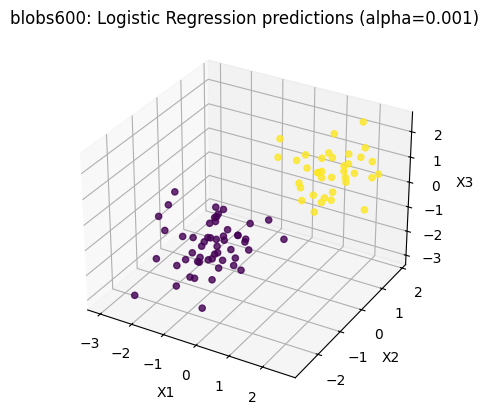

blobs600 test accuracy: 1.0


In [132]:
y_pred1 = predict_class(X_test_s1, w1, b1).reshape(-1)
correct = (y_pred1 == y1_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X1_test[:, 0], X1_test[:, 1], X1_test[:, 2], c=y_pred1, marker="o", alpha=0.8)
ax.scatter(X1_test[~correct, 0], X1_test[~correct, 1], X1_test[~correct, 2],
           facecolors="none", edgecolors="k", s=60)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
ax.set_title(f"blobs600: Logistic Regression predictions (alpha={best_alpha1})")
plt.show()

print("blobs600 test accuracy:", accuracy(y1_test, y_pred1))


INFERENCE:

- The dataset was split into Train (420 samples), Validation (90), and Test (90) with 3 input features each. I tried multiple learning rates alpha from 0.001 to 0.2, and trained each model for a large number of iterations so every option had a fair chance to learn.
- All learning rates achieved almost the same validation accuracy (0.989) and perfect test accuracy (1.000). This suggests the dataset is very easy to separate, so logistic regression can learn it well regardless of the learning rate.
- Since the validation scores were tied, the code chooses the first best option by default, so it picked alpha = 0.001.

Conclusion: Logistic regression performs extremely well on this dataset, and learning rate choice is not very sensitive here because the classes are strongly separable.

### CIRCLES500

In [133]:
X2_train, y2_train, X2_val, y2_val, X2_test, y2_test = split_70_15_15(X2, y2, seed=0)

print("\nSplit sizes:")
print("Train:", X2_train.shape, y2_train.shape)
print("Val:  ", X2_val.shape, y2_val.shape)
print("Test: ", X2_test.shape, y2_test.shape)

mu, sigma = standardize_fit(X2_train)
X2_train_s = standardize_apply(X2_train, mu, sigma)
X2_val_s   = standardize_apply(X2_val, mu, sigma)
X2_test_s  = standardize_apply(X2_test, mu, sigma)

alphas = [0.001, 0.01, 0.05, 0.1, 0.2]
# alphas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
best_alpha2, w2, b2, hist2, all_results2 = tune_learning_rate(X2_train_s, y2_train, X2_val_s, y2_val, X2_test_s, y2_test, alphas)



Split sizes:
Train: (350, 2) (350,)
Val:   (75, 2) (75,)
Test:  (75, 2) (75,)


C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3127467275.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z = float(z_mul)


Stopped: reached max_iterations.
alpha=0.001    train_acc=0.423 val_acc=0.267 test_acc=0.427
Stopped: reached max_iterations.
alpha=0.01     train_acc=0.514 val_acc=0.360 test_acc=0.573
Stopped: reached max_iterations.
alpha=0.05     train_acc=0.369 val_acc=0.373 test_acc=0.387
Stopped: reached max_iterations.
alpha=0.1      train_acc=0.443 val_acc=0.520 test_acc=0.507
Stopped: reached max_iterations.
alpha=0.2      train_acc=0.460 val_acc=0.520 test_acc=0.520

Best alpha chosen by validation accuracy: 0.1
Best: train_acc=0.443, val_acc=0.520, test_acc=0.507


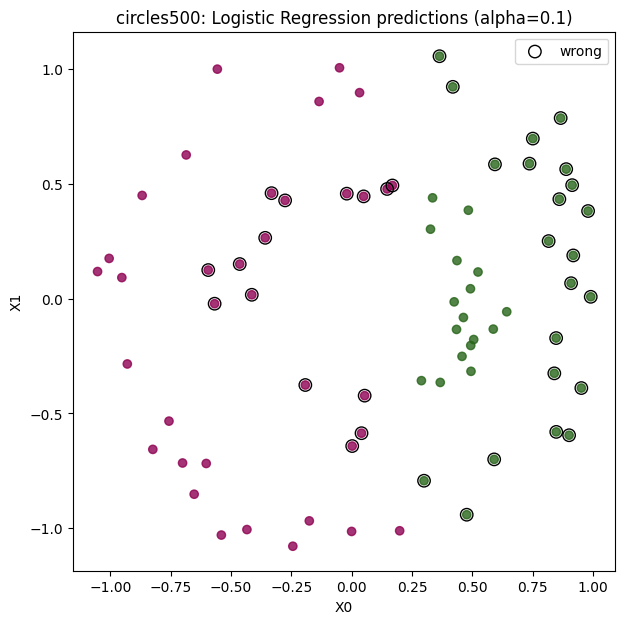

circles500 test accuracy: 0.5066666666666667


In [134]:
import matplotlib.pyplot as plt

y_pred2 = predict_class(X2_test_s, w2, b2).reshape(-1)
correct2 = (y_pred2 == y2_test)

plt.figure(figsize=(7,7))
plt.scatter(X2_test[:, 0], X2_test[:, 1], c=y_pred2, cmap="PiYG", alpha=0.8)
plt.scatter(X2_test[~correct2, 0], X2_test[~correct2, 1],
            facecolors="none", edgecolors="k", s=80, label="wrong")

plt.xlabel("X0")
plt.ylabel("X1")
plt.title(f"circles500: Logistic Regression predictions (alpha={best_alpha2})")
plt.legend()
plt.show()

print("circles500 test accuracy:", accuracy(y2_test, y_pred2))


- The dataset was split into Train (350), Validation (75), and Test (75) with 2 input features. I tried different learning rates alpha from 0.001 to 0.2, and trained each model for many iterations to see which one generalises best.
- The best validation accuracy I could get was only around 0.52, and test accuracy is about 0.51. This is close to random guessing (0.50), which tells us logistic regression is struggling on this dataset.
- The main reason is that circles500 is not linearly separable (points form inner vs outer circles), but logistic regression can only learn a straight-line decision boundary in the original feature space.
- Between the learning rates tested, alpha = 0.1 gave the highest validation score (tied with 0.2), so the model chose 0.1.

Conclusion: Logistic regression is not suitable for the circles dataset because the boundary is non-linear. This motivates using a neural network with a hidden layer (Task 3), which can learn non-linear decision boundaries.

In [135]:
print("Predicted classes:", np.unique(y_pred2, return_counts=True))
print("True classes:", np.unique(y2_test, return_counts=True))


Predicted classes: (array([0, 1]), array([36, 39]))
True classes: (array([0, 1]), array([43, 32]))


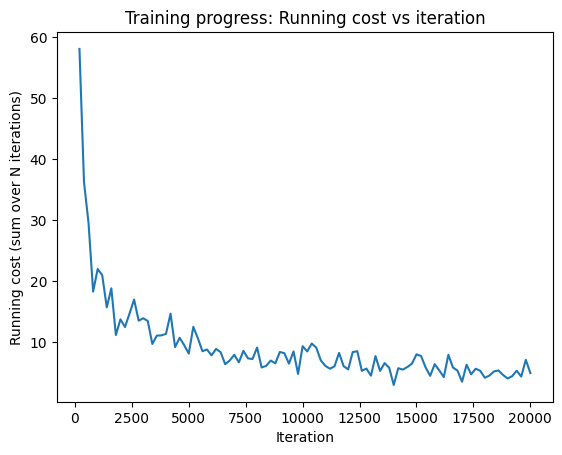

In [136]:
import matplotlib.pyplot as plt

iters = [h[0] for h in hist]
Jrun  = [h[1] for h in hist]

plt.figure()
plt.plot(iters, Jrun)
plt.xlabel("Iteration")
plt.ylabel("Running cost (sum over N iterations)")
plt.title("Training progress: Running cost vs iteration")
plt.show()


At the beginning, the cost drops really fast, this means the model quickly learns the basic pattern in the data. After a while, the curve goes down more slowly and starts to level off, which usually means the model is close to its best solution and further updates only make small improvements. The curve is a bit bumpy because am usingg SGD (updating using one random sample at a time), so small ups and downs are normal. Overall, the downward trend shows the training process is working properly.

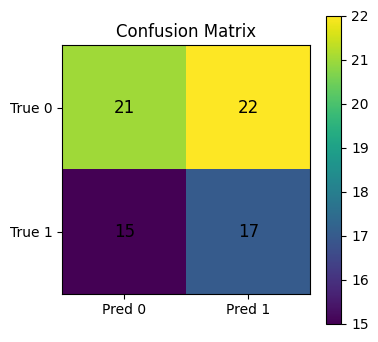

In [137]:
tp = np.sum((y2_test == 1) & (y_pred2 == 1))
tn = np.sum((y2_test == 0) & (y_pred2 == 0))
fp = np.sum((y2_test == 0) & (y_pred2 == 1))
fn = np.sum((y2_test == 1) & (y_pred2 == 0))

cm = np.array([[tn, fp],
               [fn, tp]])

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

- This confusion matrix shows exactly how many test samples the model got right and wrong for each class. The diagonal numbers (TN and TP) are the correct predictions, and the other off diagonal numbers (FP and FN) are the mistakes. 

- In this (circles) test set, the model is making a lot of mistakes in both directions, which means it’s struggling to separate the two classes.
    - True 0 predicted as 0 (TN) = 21 -> 21 class-0 points were correctly classified.
    - True 0 predicted as 1 (FP) = 22 -> 22 class-0 points were wrongly labelled as class-1 (this is high).
    - True 1 predicted as 0 (FN) = 15 -> 15 class-1 points were wrongly labelled as class-0.
    - True 1 predicted as 1 (TP) = 17 -> 17 class-1 points were correctly classified.

So out of 75 test samples, correct predictions are 21 + 17 = 38, giving accuracy:
    Accuracy = 38/75 -> ~ 0.507

That’s almost the same as guessing, which matches what we saw earlier for the circles dataset.

Conclusion: logistic regression isn’t able to learn a good boundary here because the circles data needs a non-linear decision boundary, but logistic regression can only draw a straight line in the feature space. I hope this is exactly why task shifts to a neural network with a hidden layer in Task 3.

# TASK3

In [138]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def to_col(x):
    x = np.array(x, dtype=float)
    if x.ndim == 1:
        return x.reshape(-1, 1)
    if x.ndim == 2:
        if x.shape[1] == 1:
            return x
        if x.shape[0] == 1:
            return x.reshape(-1, 1)
    raise ValueError(f"to_col: expected (n,), (n,1), or (1,n). Got {x.shape}")

def to_1d_labels(y):
    y = np.array(y)
    if y.ndim == 0:
        return y.reshape(1).astype(int)
    return y.reshape(-1).astype(int)

def accuracy(y_true, y_pred):
    y_true = to_1d_labels(y_true)
    y_pred = to_1d_labels(y_pred)
    return (y_true == y_pred).mean()


In [139]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_grad_from_a(a):
    # if a = sigmoid(z), then sigmoid'(z) = a(1-a)
    return a * (1 - a)


### shallow NN implementation

- Goal: Extend LR to 1 hidden layer:
    - Hidden layer: z1= w1 . x + b1, a1 = sigma(z1)
    - Output: z2 = w2 . a1 + b2, y' = sigma(z2)

- Backprop idea (single sample SGD):
    - Output error: delta2 = y' - y
    - Hidden error: delta1 = (w2(transpose) . delta2) * sigma'(z1)
    
- Why this solves circles: hidden layer gives non-linear representation.

Ref : 
- [1 HL Shallow NN Arch](https://medium.com/data-science-365/one-hidden-layer-shallow-neural-network-architecture-d45097f649e6)
- [Backpropagation in NN](https://www.geeksforgeeks.org/machine-learning/backpropagation-in-neural-network/)

In [140]:
def forward_nn(x_or_X, W1, b1, W2, b2, return_cache=False, debug=False):
    """
    1-hidden-layer NN forward pass (supports single sample / many samples)

    Parameters:
      W1: (h, n), b1: (h, 1)
      W2: (1, h), b2: (1, 1)

    Input:
      - single sample: (n,), (n,1), (1,n)
      - many samples:  (m,n)

    Output:
      - single sample: z2 scalar, y_prob scalar
      - many samples:  z2 (m,1), y_prob (m,1)
    """
    A = np.array(x_or_X, dtype=float)

    # -------- MANY SAMPLES (m,n) --------
    if A.ndim == 2 and A.shape[0] > 1:
        X = A  # (m,n)
        m, n = X.shape

        if W1.shape[1] != n:
            raise ValueError(f"forward_nn: X has {n} features but W1 expects {W1.shape[1]}.")

        # z1 = W1 X^T + b1  -> (h,m)
        z1 = np.dot(W1, X.T) + b1
        a1 = sigmoid(z1)  # (h,m)

        # z2 = W2 a1 + b2 -> (1,m)
        z2 = np.dot(W2, a1) + b2
        y_prob = sigmoid(z2)  # (1,m)

        # return as (m,1)
        z2_out = z2.T
        y_out = y_prob.T

        if debug:
            print("forward_nn MANY:")
            print("X:", X.shape, "z1:", z1.shape, "a1:", a1.shape, "z2:", z2_out.shape)

        if return_cache:
            return z2_out, y_out, (z1, a1, z2, y_prob)
        return z2_out, y_out

    # -------- SINGLE SAMPLE --------
    x = to_col(A)  # (n,1)
    n = x.shape[0]

    if W1.shape[1] != n:
        raise ValueError(f"forward_nn: x has {n} features but W1 expects {W1.shape[1]}.")

    z1 = np.dot(W1, x) + b1     # (h,1)
    a1 = sigmoid(z1)            # (h,1)
    z2 = np.dot(W2, a1) + b2    # (1,1)
    y_prob = sigmoid(z2)        # (1,1)

    z2_out = z2.item()
    y_out = y_prob.item()

    if debug:
        print("forward_nn SINGLE:")
        print("x:", x.shape, "z1:", z1.shape, "a1:", a1.shape, "z2:", z2_out, "y:", y_out)

    if return_cache:
        return z2_out, y_out, (z1, a1, z2, y_prob, x)
    return z2_out, y_out

In [141]:
def bce_loss(y, y_prob, eps=1e-12):
    """
    log loss:
    - y can be scalar or (m,)
    - y_prob can be scalar or (m,1) or (m,)
    returns scalar loss (avg if many)
    """
    y = to_1d_labels(y)

    # scalar prob
    if np.isscalar(y_prob):
        p = float(np.clip(y_prob, eps, 1 - eps))
        yy = int(y[0])
        return float(-(yy*np.log(p) + (1-yy)*np.log(1-p)))

    # vector prob
    p = np.array(y_prob, dtype=float).reshape(-1)
    p = np.clip(p, eps, 1 - eps)
    if p.shape[0] != y.shape[0]:
        raise ValueError("bce_loss: y and y_prob size mismatch.")
    m = y.shape[0]
    return float(-(1/m) * np.sum(y*np.log(p) + (1-y)*np.log(1-p)))


In [142]:
def backprop_one(cache, y, W2):
    """
    Backprop for ONE example using cached values from forward_nn(..., return_cache=True)
    cache for single sample contains: (z1, a1, z2, y_prob, x)
    """
    z1, a1, z2, y_prob, x = cache
    y = int(to_1d_labels(y)[0])

    # delta2 = y' - y
    delta2 = (y_prob - y)                 # (1,1)

    # dW2 = delta2 * a1(transpose)
    dW2 = np.dot(delta2, a1.T)            # (1,h)
    db2 = delta2                          # (1,1)

    # delta1 = (W2^T delta2) * sigmoid'(z1)
    delta1 = np.dot(W2.T, delta2) * sigmoid_grad_from_a(a1)  # (h,1)

    # dW1 = delta1 * x(transpose)
    dW1 = np.dot(delta1, x.T)             # (h,n)
    db1 = delta1                          # (h,1)

    return dW1, db1, dW2, db2


In [143]:
def init_params(n_inputs, n_hidden, seed=0):
    rng = np.random.default_rng(seed)

    # small random weights
    W1 = rng.normal(0, 0.1, size=(n_hidden, n_inputs))
    b1 = np.zeros((n_hidden, 1))

    W2 = rng.normal(0, 0.1, size=(1, n_hidden))
    b2 = np.zeros((1, 1))

    return W1, b1, W2, b2

In [144]:
def fit_shallow_nn_sgd(X, y, n_hidden=8, alpha=0.1, max_iterations=300000,
                       threshold=1e-4, N=None, seed=0, debug_every_N=True):
    """
    training shallow NN (1 hidden layer, 1 output node) using single-example SGD.
    """
    X = np.array(X, dtype=float)
    y = to_1d_labels(y)
    m, n = X.shape

    if N is None:
        N = m

    W1, b1, W2, b2 = init_params(n, n_hidden, seed=seed)
    rng = np.random.default_rng(seed)

    J_running = 0.0
    J_prev = 0.0
    history = []
    iteration = 0

    while True:
        # here it picks 1 random sample
        i = rng.integers(0, m)
        x_i = X[i]     # (n,)
        y_i = y[i]     # 0/1

        # forward (single sample) + cache
        _, y_prob, cache = forward_nn(x_i, W1, b1, W2, b2, return_cache=True)

        # loss (single)
        J_current = bce_loss(y_i, y_prob)

        # backprop grad
        dW1, db1g, dW2, db2g = backprop_one(cache, y_i, W2)

        # updation of w and b
        W1 = W1 - alpha * dW1
        b1 = b1 - alpha * db1g
        W2 = W2 - alpha * dW2
        b2 = b2 - alpha * db2g

        iteration += 1
        J_running += J_current

        # stop if max iterations
        if iteration >= max_iterations:
            if debug_every_N:
                print("Stopped: reached max_iterations.")
            break

        # checks for convergence every N steps
        if iteration % N == 0:
            change = abs(J_running - J_prev)
            history.append((iteration, J_running, change))

            if debug_every_N:
                print(f"After {iteration} iters: J_running={J_running:.4f}, change={change:.6f}")

            if change < threshold:
                if debug_every_N:
                    print("Stopped: convergence reached.")
                break

            J_prev = J_running
            J_running = 0.0

    return W1, b1, W2, b2, history

In [145]:
def predict_proba_nn(X, W1, b1, W2, b2):
    _, y_prob = forward_nn(X, W1, b1, W2, b2)  # many-sample path
    return y_prob.reshape(-1)

def predict_class_nn(X, W1, b1, W2, b2, threshold=0.5):
    probs = predict_proba_nn(X, W1, b1, W2, b2)
    return (probs >= threshold).astype(int)


In [146]:
def evaluate_hidden_sizes(X_train, y_train, X_val, y_val, X_test, y_test,
                          hidden_list, alpha=0.1, max_iterations=300000,
                          threshold=1e-4, seed=0):
    results = []
    for h in hidden_list:
        W1, b1, W2, b2, hist = fit_shallow_nn_sgd(
            X_train, y_train,
            n_hidden=h,
            alpha=alpha,
            max_iterations=max_iterations,
            threshold=threshold,
            N=len(X_train),
            seed=seed,
            debug_every_N=False
        )

        ytr = predict_class_nn(X_train, W1, b1, W2, b2)
        yva = predict_class_nn(X_val,   W1, b1, W2, b2)
        yte = predict_class_nn(X_test,  W1, b1, W2, b2)

        tr_acc = accuracy(y_train, ytr)
        va_acc = accuracy(y_val, yva)
        te_acc = accuracy(y_test, yte)

        results.append((h, tr_acc, va_acc, te_acc, W1, b1, W2, b2, hist))
        print(f"h={h:<3} train={tr_acc:.3f} val={va_acc:.3f} test={te_acc:.3f}")

    best = max(results, key=lambda r: r[2])  # choose best by val accuracy
    print("\nBest hidden size by validation:", best[0], "| val_acc:", best[2])
    return results, best


### Test different hidden sizes

- Goal: Experiment with h -> {2,4,8,16} & compare train/val/test.
- Inference:
    - circles improves dramatically with more hidden units
    - blobs already easy; hidden size doesn’t matter much

In [147]:
hidden_list = [2, 4, 8, 16]

print("=== circles500 (2D) shallow NN ===")
circles_results, circles_best = evaluate_hidden_sizes(
    X2_train_s, y2_train,
    X2_val_s, y2_val,
    X2_test_s, y2_test,
    hidden_list,
    alpha=0.1,
    max_iterations=50000,
    threshold=1e-4,
    seed=0
)

print("\n=== blobs600 (3D) shallow NN ===")
blobs_results, blobs_best = evaluate_hidden_sizes(
    X_train_s1, y1_train,
    X_val_s1, y1_val,
    X_test_s1, y1_test,
    hidden_list,
    alpha=0.1,
    max_iterations=50000,
    threshold=1e-4,
    seed=0
)


=== circles500 (2D) shallow NN ===
h=2   train=0.757 val=0.667 test=0.667
h=4   train=0.994 val=0.973 test=1.000
h=8   train=1.000 val=1.000 test=1.000
h=16  train=1.000 val=0.987 test=1.000

Best hidden size by validation: 8 | val_acc: 1.0

=== blobs600 (3D) shallow NN ===
h=2   train=0.998 val=0.989 test=1.000
h=4   train=0.998 val=0.989 test=1.000
h=8   train=0.998 val=0.989 test=1.000
h=16  train=0.998 val=0.989 test=1.000

Best hidden size by validation: 2 | val_acc: 0.9888888888888889


- Adding one hidden layer completely changes what the model can learn. On circles500, logistic regression struggled because it can only draw a straight line boundary, but the shallow NN learns a non-linear boundary, so accuracy jumps to ~100% when hidden nodes are enough (best at h=8). 
- On blobs600, the data is already easy and almost linearly separable, so even a small hidden layer (h=2) achieves near-perfect performance and increasing hidden nodes doesn’t really help.

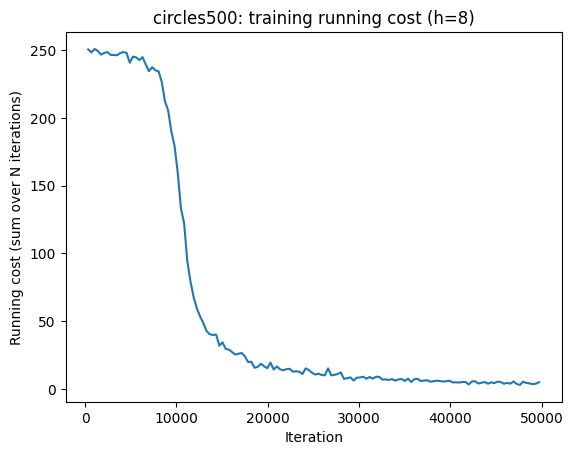

In [148]:
best_h, tr_acc, va_acc, te_acc, W1, b1, W2, b2, hist = circles_best

iters = [t[0] for t in hist]
Jrun  = [t[1] for t in hist]

plt.figure()
plt.plot(iters, Jrun)
plt.xlabel("Iteration")
plt.ylabel("Running cost (sum over N iterations)")
plt.title(f"circles500: training running cost (h={best_h})")
plt.show()


The cost stays high at the start, then suddenly drops sharply, which shows the network finally finds a good non-linear separation after enough updates. After that, it slowly flattens out near zero, meaning the model has basically learned the pattern and is only making tiny improvements.

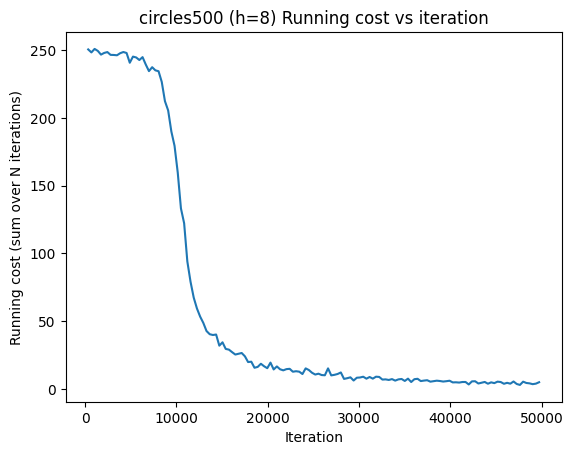

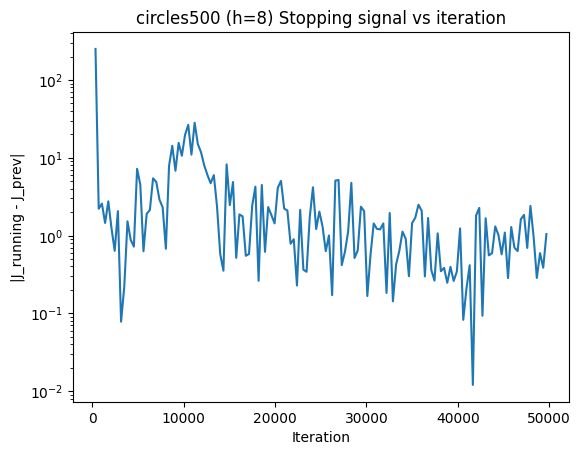

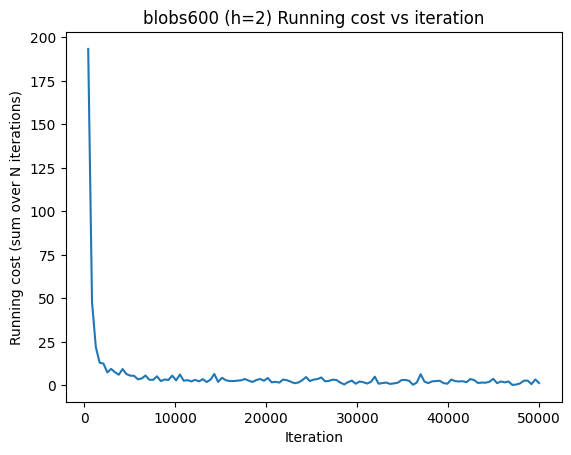

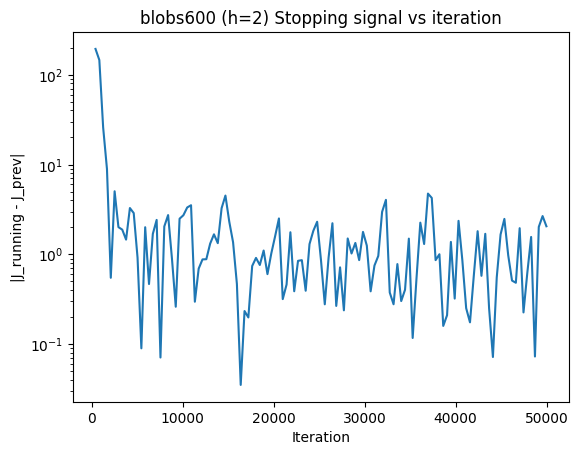

In [149]:
import matplotlib.pyplot as plt

def plot_loss_history(hist, title_prefix=""):
    iters  = [h[0] for h in hist]
    Jrun   = [h[1] for h in hist]
    change = [h[2] for h in hist]

    # Running cost plot
    plt.figure()
    plt.plot(iters, Jrun)
    plt.xlabel("Iteration")
    plt.ylabel("Running cost (sum over N iterations)")
    plt.title(f"{title_prefix} Running cost vs iteration")
    plt.show()

    # Stopping signal plot
    plt.figure()
    plt.plot(iters, change)
    plt.xlabel("Iteration")
    plt.ylabel("|J_running - J_prev|")
    plt.title(f"{title_prefix} Stopping signal vs iteration")
    plt.yscale("log")
    plt.show()

# --- circles ---
best_hc, tr_acc_c, va_acc_c, te_acc_c, W1c, b1c, W2c, b2c, hist_c = circles_best
plot_loss_history(hist_c, title_prefix=f"circles500 (h={best_hc})")

# --- blobs ---
best_hb, tr_acc_b, va_acc_b, te_acc_b, W1b, b1b, W2b, b2b, hist_b = blobs_best
plot_loss_history(hist_b, title_prefix=f"blobs600 (h={best_hb})")


1) circles500: running cost vs iteration (h=8) (similar cost curve)

This shows the same story, the model improves a lot after a certain point and then settles. The small bumps are normal because the use of SGD, so each update is based on a random sample and the cost can wiggle a bit.

2) circles500: stopping signal vs iteration (h=8) (log-scale change plot)

At the beginning the change is huge (model learning fast), but later the changes become much smaller overall. The curve is noisy because SGD is random, but the general trend tells us training is stabilising and getting close to convergence.

3) blobs600: running cost vs iteration (h=2) (cost curve)

The cost drops extremely fast and becomes tiny early on, showing blobs are easy to separate. After that it stays low and flat, which means the model converged quickly.

4) blobs600: stopping signal vs iteration (h=2) (log-scale change plot)

The change starts very large then quickly becomes small, which means training reaches a stable point early. Any remaining spikes are just SGD noise and don’t affect the fact that the model has already learned the dataset well.

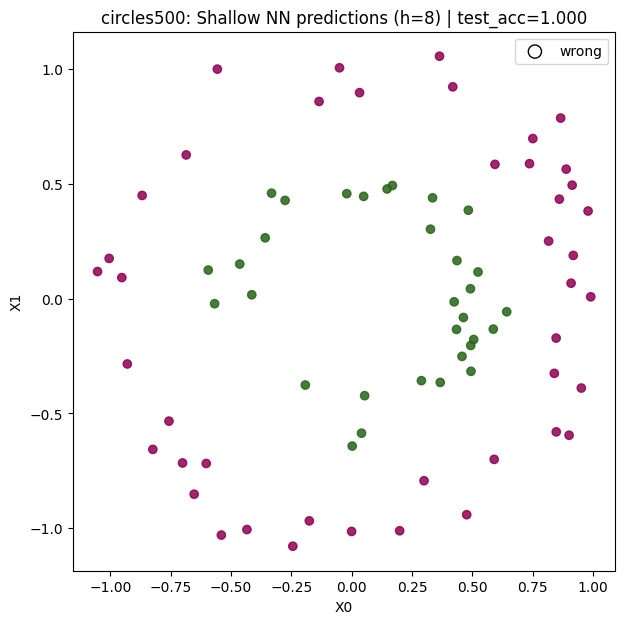

circles500 predicted class counts: (array([0, 1]), array([43, 32]))
circles500 test accuracy: 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_pred_c = predict_class_nn(X2_test_s, W1c, b1c, W2c, b2c).reshape(-1)
correct_c = (y_pred_c == y2_test)

plt.figure(figsize=(7,7))
plt.scatter(X2_test[:, 0], X2_test[:, 1], c=y_pred_c, cmap="PiYG", alpha=0.85)
plt.scatter(X2_test[~correct_c, 0], X2_test[~correct_c, 1],
            facecolors="none", edgecolors="k", s=90, label="wrong")

plt.xlabel("X0")
plt.ylabel("X1")
plt.title(f"circles500: Shallow NN predictions (h={best_hc}) | test_acc={te_acc_c:.3f}")
plt.legend()
plt.show()

print("circles500 predicted class counts:", np.unique(y_pred_c, return_counts=True))
print("circles500 test accuracy:", accuracy(y2_test, y_pred_c))


circles500 scatter: Shallow NN predictions (h=8), test_acc=1.0

The predicted colors form a clear inner vs outer circle split, which is exactly what we expect for circles data. The wrong markers are basically absent, matching the 100% test accuracy.

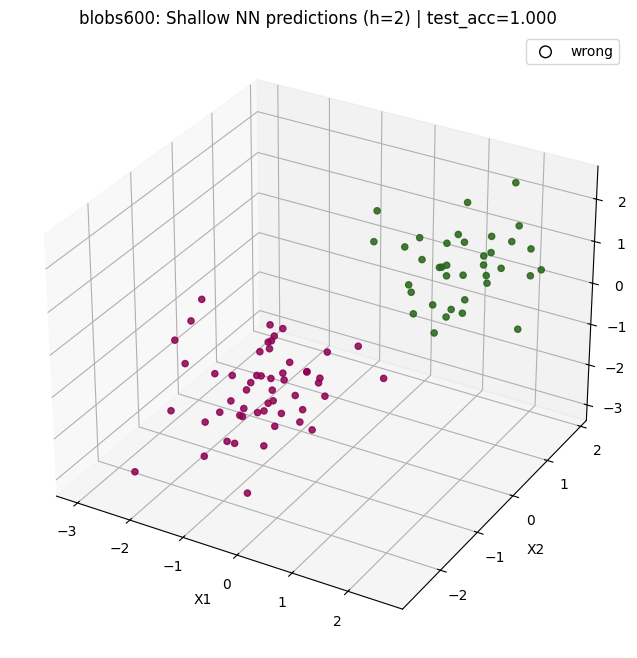

blobs600 test accuracy: 1.0


In [ ]:
y_pred_b = predict_class_nn(X_test_s1, W1b, b1b, W2b, b2b).reshape(-1)
correct_b = (y_pred_b == y1_test)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X1_test[:, 0], X1_test[:, 1], X1_test[:, 2], c=y_pred_b, cmap="PiYG", alpha=0.85)
ax.scatter(X1_test[~correct_b, 0], X1_test[~correct_b, 1], X1_test[~correct_b, 2],
           facecolors="none", edgecolors="k", s=70, label="wrong")

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")
ax.set_title(f"blobs600: Shallow NN predictions (h={best_hb}) | test_acc={te_acc_b:.3f}")
ax.legend()
plt.show()

print("blobs600 test accuracy:", accuracy(y1_test, y_pred_b))


blobs600 3D scatter: Shallow NN predictions (h=2), test_acc=1.0

The two clusters are cleanly separated in 3D space, so the model can classify them almost perfectly even with a small hidden layer. This explains why increasing hidden nodes doesn’t improve accuracy, it’s already solved.

REF: [Confusion matrix from scratch](https://codesignal.com/learn/courses/classification-algorithms-and-metrics/lessons/understanding-the-confusion-matrix-precision-and-recall-in-classification-metrics#:~:text=Implementing%20Confusion%20Matrix%20in%20Python)

In [182]:
def confusion_counts(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1).astype(int)
    y_pred = np.array(y_pred).reshape(-1).astype(int)

    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    return TN, FP, FN, TP

def plot_confusion_matrix(TN, FP, FN, TP, title="Confusion Matrix", class0="Class 0", class1="Class 1"):
    cm = np.array([[TN, FP],[FN, TP]])

    plt.figure(figsize=(4,4))
    plt.imshow(cm)
    plt.xticks([0,1], [f"Pred {class0}", f"Pred {class1}"])
    plt.yticks([0,1], [f"True {class0}", f"True {class1}"])

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center", fontsize=12)

    plt.title(title)
    plt.colorbar()
    plt.show()

circles500 confusion matrix:
TN: 43 FP: 0
FN: 0 TP: 32


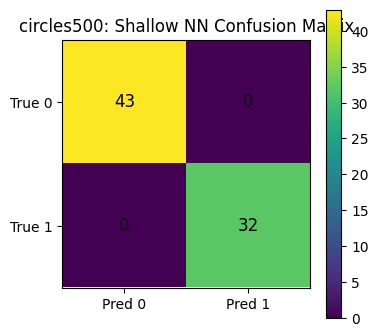

blobs600 confusion matrix:
TN: 53 FP: 0
FN: 0 TP: 37


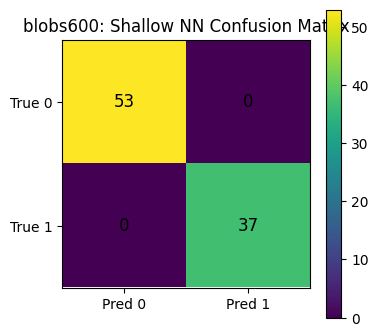

In [ ]:
TN, FP, FN, TP = confusion_counts(y2_test, y_pred_c)
print("circles500 confusion matrix:")
print("TN:", TN, "FP:", FP)
print("FN:", FN, "TP:", TP)

plot_confusion_matrix(TN, FP, FN, TP,title="circles500: Shallow NN Confusion Matrix",
                      class0="0", class1="1")

TN, FP, FN, TP = confusion_counts(y1_test, y_pred_b)
print("blobs600 confusion matrix:")
print("TN:", TN, "FP:", FP)
print("FN:", FN, "TP:", TP)

plot_confusion_matrix(TN, FP, FN, TP, title="blobs600: Shallow NN Confusion Matrix",
                      class0="0", class1="1")


### CONCLUSION:

- circles500 hidden-size:

    - With h=2, the network doesn’t have enough capacity, so accuracy is only moderate. Once we reach h=4 or h=8, the model has enough hidden units to learn a strong non-linear boundary, and performance becomes nearly perfect. h=8 is chosen as best because it gives the highest validation accuracy without unnecessary extra complexity.

- blobs600 hidden-size:

    - Even h=2 already achieves near perfect performance because blobs are simple and close to linearly separable. Adding more hidden nodes doesn’t change results because the dataset doesn’t need extra complexity.

# TASK 4

- Goal: Convert 26-class EMNIST letters into a binary dataset:
    - select only F and L
    - relabel to {0,1}: 0 = F ; 1 = L

- Why flatten:
    - 28×28 image -> 784 input features for NN.

- Sanity checks:
    - counts near 3300 per class
    - sample plots look like F and L

In [152]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load("emnist_letters_85800.npz")

x_data = data["x"]
y_data = data["y"]

In [153]:
# Do some data checks ...

# Check how many different classes we have: should be 26
n_classes =len(np.unique(y_data))
print(f"The number of unique classes is {n_classes} (should be 26).")

# check that images are scaled: min should be 0, max should be 1
img = x_data[0]
print(f"\nFor a single image, the min value is {img.min()} and the max is {img.max()} (should be 0.0 and 1.0).")

# Check the shape of the two classes
print(f"\nShape of x_data is {x_data.shape}, shape of y_data is {y_data.shape} (should have 85,800 cases and x should be 28x28).")

The number of unique classes is 26 (should be 26).

For a single image, the min value is 0.0 and the max is 1.0 (should be 0.0 and 1.0).

Shape of x_data is (85800, 28, 28, 1), shape of y_data is (85800,) (should have 85,800 cases and x should be 28x28).


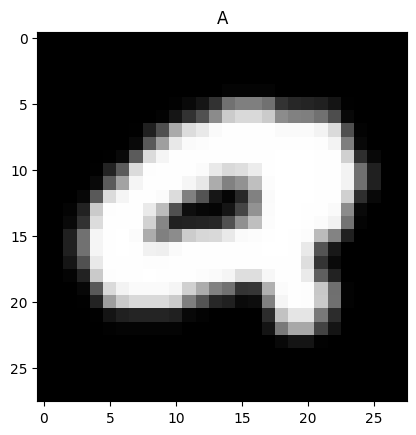

In [154]:
# Plot the first image

plt.imshow(x_data[0].squeeze(), cmap="gray")
plt.title(chr(int(y_data[0]) + 64))  
plt.show()

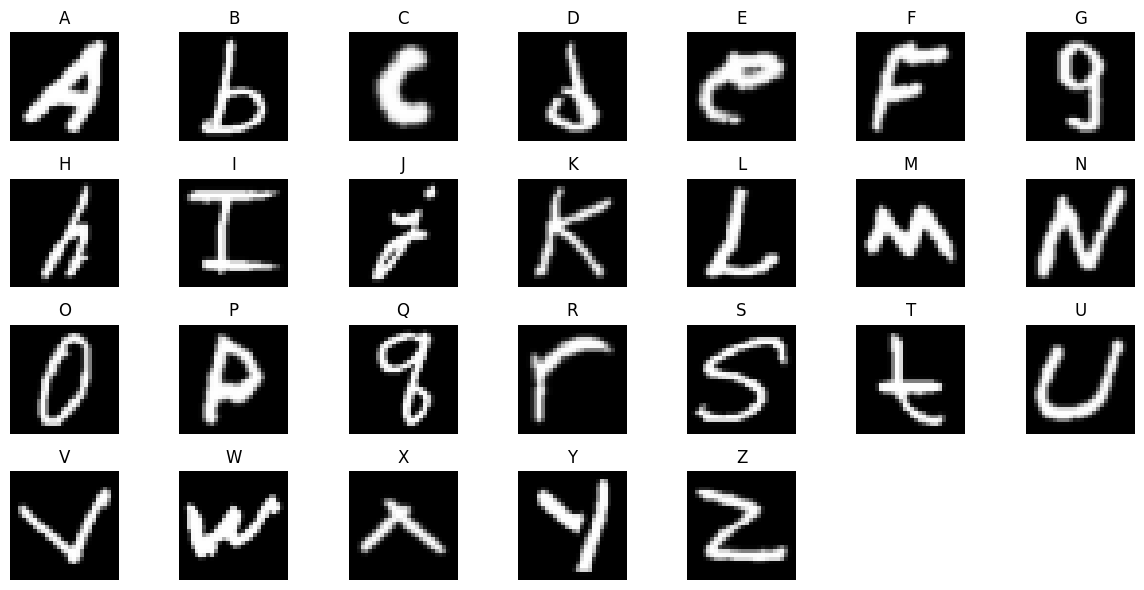

In [155]:

# Plot one item per class
n = 1000  # plot the n-th item, starting from 0

# Get unique labels
classes = np.unique(y_data)

plt.figure(figsize=(12, 6))

for i, cls in enumerate(classes):
    # Find first index of this class
    idx = np.where(y_data == cls)[0][n]
    
    plt.subplot(4, 7, i + 1)
    plt.imshow(x_data[idx].squeeze(), cmap="gray")
    plt.title(chr(int(cls) + 64))  # 1->A, 2->B, ...
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Extract just two classes from the dataset

# PUT YOUR OWN CLASS NUMBERS HERE: remember that A=1, z=26.
c1 = 6   # F
c2 = 12  # L

mask = (y_data == c1) | (y_data == c2)

x_binary = x_data[mask]
y_binary = y_data[mask]

# Now change labels to 0 and 1
y_binary = (y_binary == c2).astype(int)

print("Binary X shape:", x_binary.shape)
print("Binary y shape:", y_binary.shape)
print("Counts (0=F, 1=L):", np.unique(y_binary, return_counts=True))

Binary X shape: (6600, 28, 28, 1)
Binary y shape: (6600,)
Counts (0=F, 1=L): (array([0, 1]), array([3300, 3300]))


In [157]:
# To help you examine your data, here is a graph to plot 48  images in a grid, starting from an index you specify.

def plot_grid(x, y, n):
    plt.figure(figsize=(12, 10))
    
    for i in range(48):
        idx = n + i
        
        plt.subplot(6, 8, i + 1)
        plt.imshow(x[idx].squeeze(), cmap="gray")
        plt.title(int(y[idx]))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

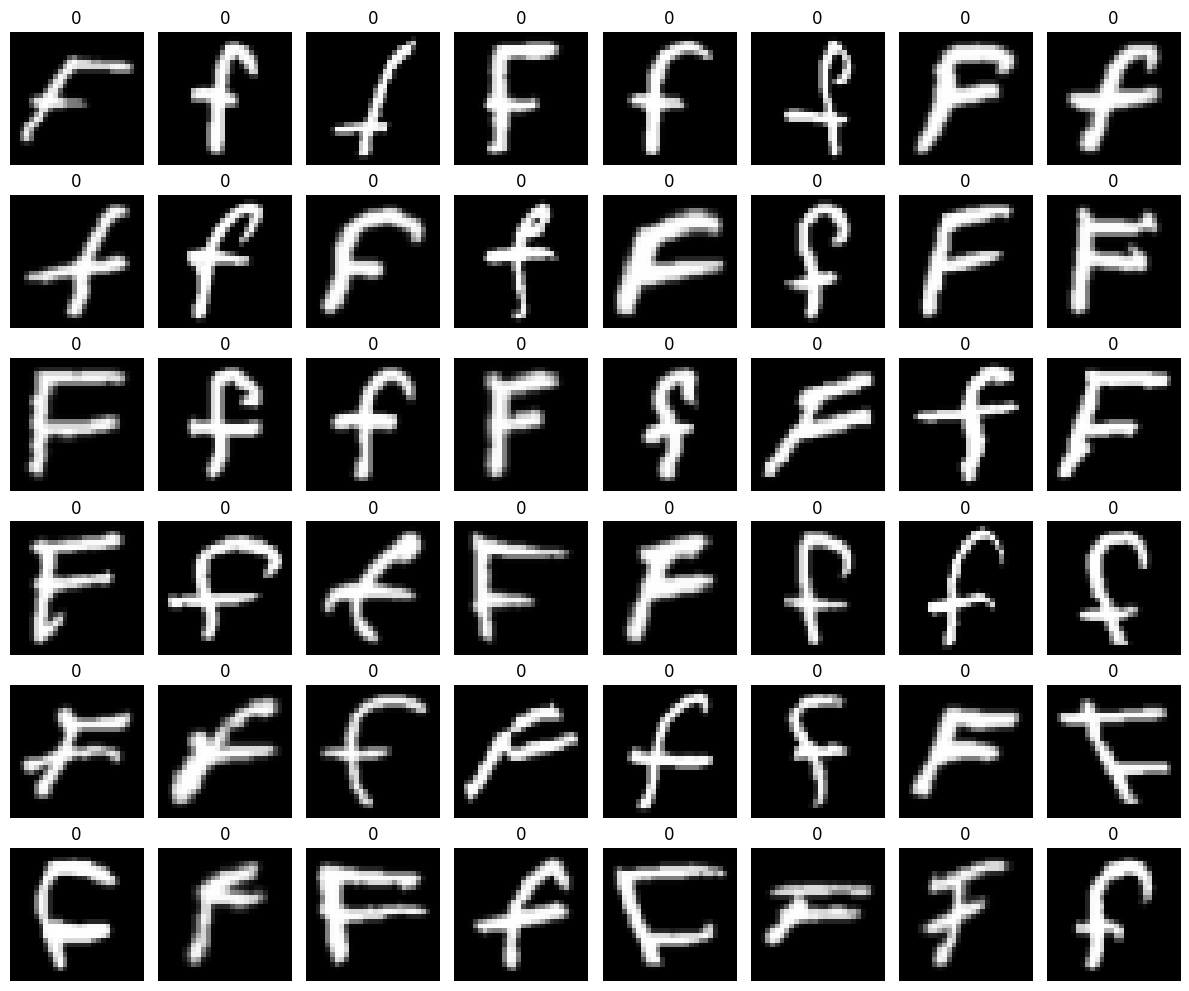

In [158]:
plot_grid(x_binary, y_binary, n=0)

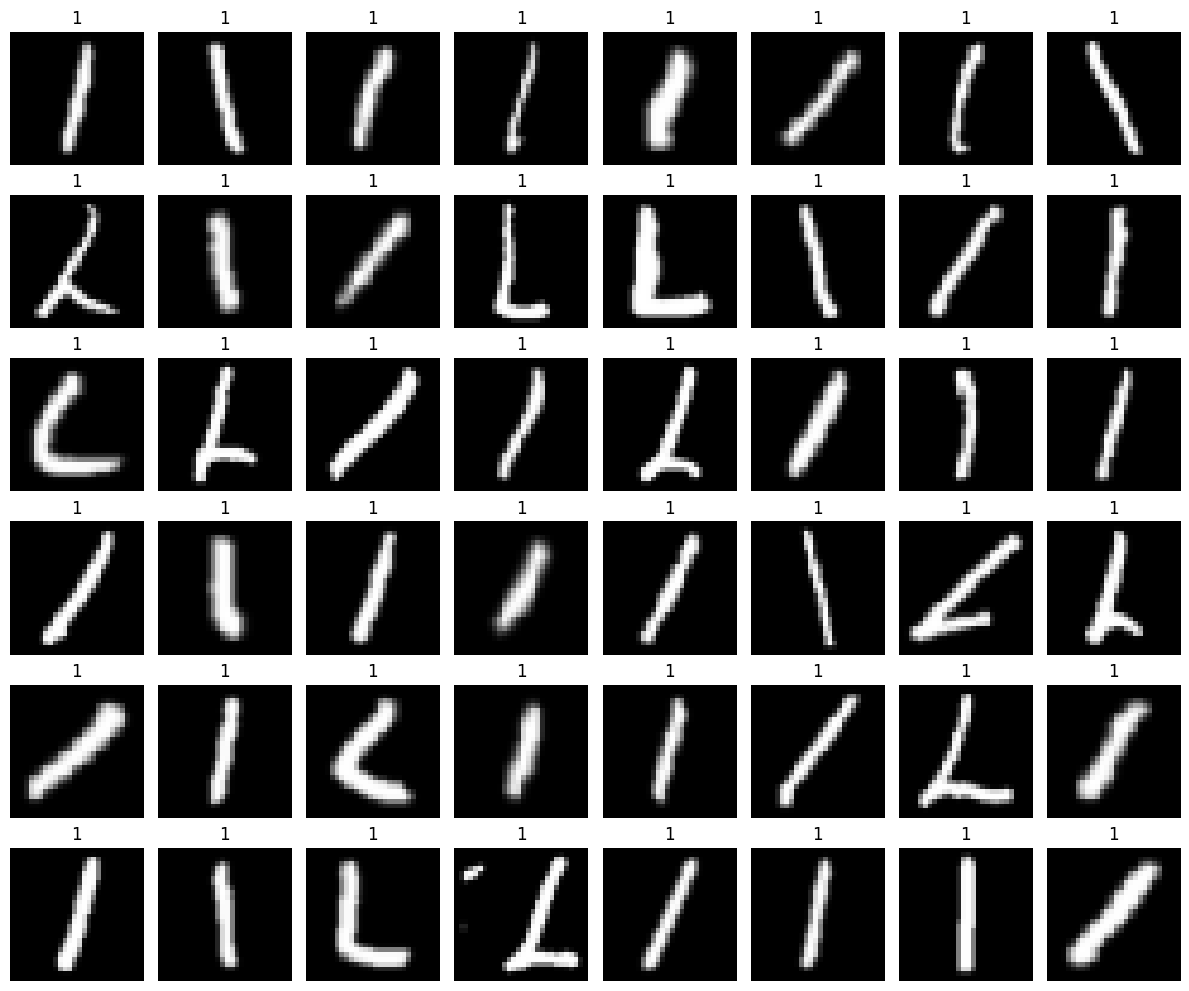

In [159]:
# Now check images after 3300 - will all have label 1

plot_grid(x_binary, y_binary, n=3300)

In [160]:
X = x_binary.reshape(x_binary.shape[0], -1)   # (m, 784)
y = y_binary.reshape(-1)                      # (m,)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6600, 784)
y shape: (6600,)


### Split + standardize + train

- Goal: Same pipeline as before:

    - 70/15/15 split
    - standardize using train only
    - train with bigger hidden nodes (32/64/128)

- Why bigger hidden layer: more inputs (784) -> needs more capacity than 2D datasets.

Ref: [Optimal size of hidden layer](https://medium.com/@mohamedgele2000/optimal-number-of-hidden-layers-in-neural-network-should-we-prefer-a-large-hidden-layer-or-a-small-25aec51f101b)

In [186]:
def split_70_15_15(X, y, seed=0):
    X = np.array(X, dtype=float)
    y = np.array(y).reshape(-1).astype(int)

    m = X.shape[0]
    rng = np.random.default_rng(seed)
    idx = np.arange(m)
    rng.shuffle(idx)

    X = X[idx]
    y = y[idx]

    n_train = int(0.70 * m)
    n_val   = int(0.15 * m)

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val     = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test, y_test   = X[n_train+n_val:], y[n_train+n_val:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_70_15_15(X, y, seed=0)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train: (4620, 784) (4620,)
Val:   (990, 784) (990,)
Test:  (990, 784) (990,)


In [187]:
def standardize_fit(X_train):
    mu = X_train.mean(axis=0, keepdims=True)
    sigma = X_train.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(X, mu, sigma):
    return (X - mu) / sigma

mu, sigma = standardize_fit(X_train)
X_train_s = standardize_apply(X_train, mu, sigma)
X_val_s   = standardize_apply(X_val, mu, sigma)
X_test_s  = standardize_apply(X_test, mu, sigma)

In [163]:
hidden_list = [32, 64, 128]
alpha_list = [0.05, 0.1, 0.2]

best = None  # (val_acc, h, alpha, W1,b1,W2,b2,hist)

for h in hidden_list:
    for a in alpha_list:
        W1, b1, W2, b2, hist = fit_shallow_nn_sgd(
            X_train_s, y_train,
            n_hidden=h,
            alpha=a,
            max_iterations=100000,
            threshold=1e-4,
            N=len(X_train_s),
            seed=0,
            debug_every_N=False
        )

        y_val_pred = predict_class_nn(X_val_s, W1, b1, W2, b2)
        val_acc = accuracy(y_val, y_val_pred)

        print(f"h={h:<4} alpha={a:<4} val_acc={val_acc:.3f}")

        if (best is None) or (val_acc > best[0]):
            best = (val_acc, h, a, W1, b1, W2, b2, hist)

best_val_acc, best_h, best_alpha, W1b, b1b, W2b, b2b, hist_best = best
print("\nBest model by validation:")
print("hidden:", best_h, "alpha:", best_alpha, "val_acc:", best_val_acc)


C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3500915864.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


h=32   alpha=0.05 val_acc=0.979
h=32   alpha=0.1  val_acc=0.981
h=32   alpha=0.2  val_acc=0.987
h=64   alpha=0.05 val_acc=0.981
h=64   alpha=0.1  val_acc=0.984
h=64   alpha=0.2  val_acc=0.977
h=128  alpha=0.05 val_acc=0.982
h=128  alpha=0.1  val_acc=0.988
h=128  alpha=0.2  val_acc=0.981

Best model by validation:
hidden: 128 alpha: 0.1 val_acc: 0.9878787878787879


Tried different hidden sizes and learning rates shows performance changes slightly, but the best validation result came from h=128, alpha=0.1. That combination gives enough capacity to learn the 784 pixel input without making training unstable.

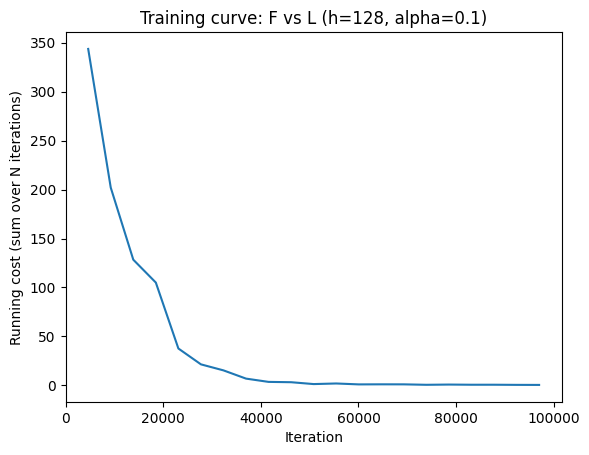

In [164]:
iters = [t[0] for t in hist_best]
Jrun  = [t[1] for t in hist_best]

plt.figure()
plt.plot(iters, Jrun)
plt.xlabel("Iteration")
plt.ylabel("Running cost (sum over N iterations)")
plt.title(f"Training curve: F vs L (h={best_h}, alpha={best_alpha})")
plt.show()


The cost falls very quickly and then becomes almost flat near zero. That means the model learned the main pattern early and then just fine-tuned small details as training continued basically it has converged.

In [188]:
y_train_pred = predict_class_nn(X_train_s, W1b, b1b, W2b, b2b)
y_val_pred   = predict_class_nn(X_val_s,   W1b, b1b, W2b, b2b)
y_test_pred  = predict_class_nn(X_test_s,  W1b, b1b, W2b, b2b)

print("Train acc:", accuracy(y_train, y_train_pred))
print("Val acc:  ", accuracy(y_val, y_val_pred))
print("Test acc: ", accuracy(y_test, y_test_pred))

TN = np.sum((y_test == 0) & (y_test_pred == 0))
FP = np.sum((y_test == 0) & (y_test_pred == 1))
FN = np.sum((y_test == 1) & (y_test_pred == 0))
TP = np.sum((y_test == 1) & (y_test_pred == 1))


Train acc: 1.0
Val acc:   0.9878787878787879
Test acc:  0.9929292929292929


C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3500915864.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


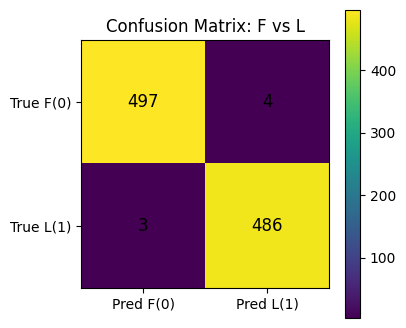

In [190]:
cm = np.array([[TN, FP],
               [FN, TP]])

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.xticks([0,1], ["Pred F(0)", "Pred L(1)"])
plt.yticks([0,1], ["True F(0)", "True L(1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", fontsize=12)

plt.title("Confusion Matrix: F vs L")
plt.colorbar()
plt.show()


Most predictions are correct (big numbers on the diagonal). Only 4 F’s were wrongly called L, and 3 L’s were wrongly called F, so the model is getting almost everything right.

C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3500915864.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


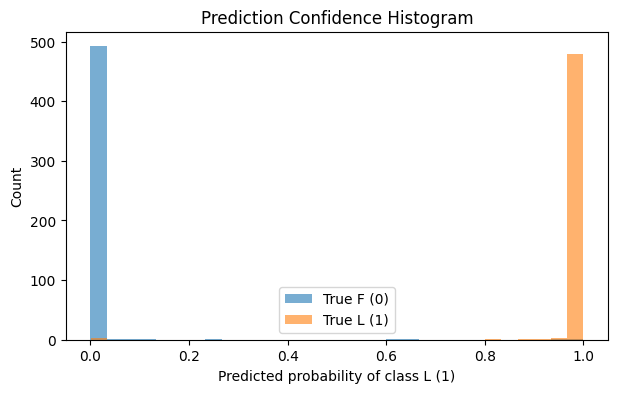

In [167]:
probs_test = predict_proba_nn(X_test_s, W1b, b1b, W2b, b2b)  # (m,)

plt.figure(figsize=(7,4))
plt.hist(probs_test[y_test==0], bins=30, alpha=0.6, label="True F (0)")
plt.hist(probs_test[y_test==1], bins=30, alpha=0.6, label="True L (1)")
plt.xlabel("Predicted probability of class L (1)")
plt.ylabel("Count")
plt.title("Prediction Confidence Histogram")
plt.legend()
plt.show()


- Able to see 2 strong peaks: 
    - True F (0) is pushed near probability 0
    - True L (1) is pushed near probability 1
That means the model isn’t just correct, it’s usually very confident when it predicts.

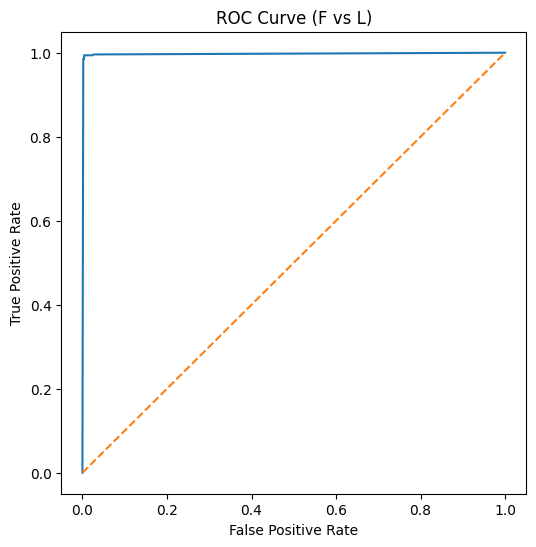

In [ ]:
def roc_curve_points(y_true, probs):
    thresholds = np.linspace(0, 1, 200)
    tpr_list, fpr_list = [], []

    for t in thresholds:
        y_pred = (probs >= t).astype(int)
        TP = np.sum((y_true==1) & (y_pred==1))
        FP = np.sum((y_true==0) & (y_pred==1))
        TN = np.sum((y_true==0) & (y_pred==0))
        FN = np.sum((y_true==1) & (y_pred==0))

        tpr = TP / (TP + FN + 1e-12)
        fpr = FP / (FP + TN + 1e-12)

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list)

fpr, tpr = roc_curve_points(y_test, probs_test)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
# rand baseline drawn
plt.plot([0,1], [0,1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (F vs L)")
plt.show()


The curve hugs the top left corner, far above the diagonal random guessing line. This means the model separates F and L extremely well across different thresholds (very high TPR with very low FPR).

Num wrong: 7


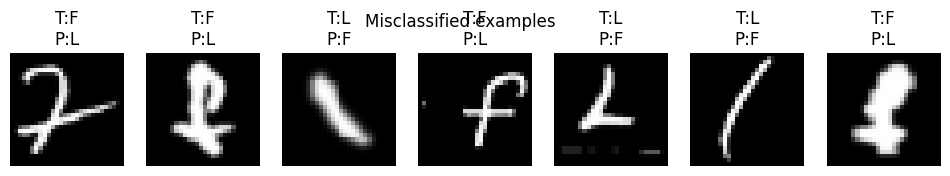

In [169]:
wrong = np.where(y_test_pred != y_test)[0]
print("Num wrong:", len(wrong))

n = min(10, len(wrong))
plt.figure(figsize=(12,2))
for i in range(n):
    idx = wrong[i]
    plt.subplot(1, n, i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap="gray")
    plt.title(f"T:{'L' if y_test[idx]==1 else 'F'}\nP:{'L' if y_test_pred[idx]==1 else 'F'}")
    plt.axis("off")
plt.suptitle("Misclassified examples")
plt.show()


The few wrong images look like messy handwriting cases where F and L shapes can resemble each other (missing strokes, extra curves/ very faint writing). These are the natural hard cases in real handwriting.

### CONCLUSION

- Using the same one-hidden-layer neural network from Task 3 (with 784 inputs, h=128, alpha=0.1), the model achieved:
    - Train accuracy = 1.000
    - Validation accuracy ~ 0.988
    - Test accuracy ~ 0.993

- The confusion matrix (TN=497, FP=4, FN=3, TP=486) shows only 7 errors in the whole test set. 
- The training curve and confidence histogram also confirm that the model converged and makes highly confident predictions for most samples. 
- Overall, a single hidden layer is sufficient to distinguish F vs L very accurately, with remaining errors mainly coming from ambiguous handwriting.

# TASK 5

- In this task I extend my 1-hidden-layer neural network to support an arbitrary number of layers, where each layer can have a different number of nodes (given by a list like[784,128,64,1]).
- I also add a simple method to reduce overfitting on a small dataset: L2 regularization (weight decay).
- Finally, I evaluate the deep network on the Task 4 dataset (F vs L) and compare performance against the previous 1-hidden-layer baseline, including results with and without regularization.

Parameter initialization for an arbitrary number of layers

Here I initialize weights and biases for the architecture defined by a list:
[n0,n1,..nL]

where n0 is input size and nL = 1 is the output node. For each layer l, weights and biases are:

W^l -> R^(nl * nl-1), b^l -> R^(nl * 1)

They are stored in a dictionary like W1, b1, W2, b2,..

In [ ]:
# parameter initialization for an arbitrary number of layers
def init_params_deep(layers, seed=0):
    rng = np.random.default_rng(seed)
    params = {}
    for l in range(1, len(layers)):
        n_in = layers[l-1]
        n_out = layers[l]
        params[f"W{l}"] = rng.normal(0, 0.1, size=(n_out, n_in))
        params[f"b{l}"] = np.zeros((n_out, 1))
    return params

Compute the output probability by applying the same pattern repeatedly across layers:

For layer l:
    Z^l = W^l . a^(l-1) + b^l, a^l = sigma(z^l)

with a^0 = x (1 / many samples)

The final activation: a^L is the predicted probability:
    y' = a^L

I also store intermediate values (Z^l, A^l) in a cache so backpropagation can reuse them.

In [ ]:
def forward_deep(x_or_X, params, return_cache=False):
    A = np.array(x_or_X, dtype=float)

    # many samples: X is (m,n)
    if A.ndim == 2 and A.shape[0] > 1:
        X = A
        A_prev = X.T  # (n, m)
        cache = {"A0": A_prev}

        L = len([k for k in params.keys() if k.startswith("W")])
        for l in range(1, L+1):
            W = params[f"W{l}"]
            b = params[f"b{l}"]
            Z = W @ A_prev + b # (n_l, m)
            A_prev = sigmoid(Z)  # (n_l, m)
            cache[f"Z{l}"] = Z
            cache[f"A{l}"] = A_prev

        y_prob = A_prev.T # (m,1)
        if return_cache:
            return y_prob, cache
        return y_prob

    # SINGLE sample
    x = to_col(A)  # (n,1)
    A_prev = x
    cache = {"A0": A_prev}

    L = len([k for k in params.keys() if k.startswith("W")])
    for l in range(1, L+1):
        W = params[f"W{l}"]
        b = params[f"b{l}"]
        Z = W @ A_prev + b
        A_prev = sigmoid(Z)
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A_prev

    y_prob = float(A_prev) #scalar
    if return_cache:
        return y_prob, cache
    return y_prob

### Loss function: Binary Cross Entropy (BCE) + L2 penalty

- The main loss for binary classification is binary cross entropy.
- To reduce overfitting, I add L2 regularization (weight decay)
    J = J (BCE) + lambda / 2m . Summation(l=1 to L) || W^l || ^2 
- When lambda = 0, there is no regularization.
- When lambda > 0, large weights are penalized, encouraging simpler models.

REF: [L2 Penalty - Ridge loss](https://machinelearningmastery.com/ridge-regression-with-python/#:~:text=One%20popular%20penalty%20is%20to%20penalize%20a%20model%20based%20on%20the%20sum%20of%20the%20squared%20coefficient%20values%20(beta).%20This%20is%20called%20an%20L2%20penalty.)

In [172]:
def bce_loss(y, y_prob, eps=1e-12):
    y = to_1d_labels(y)

    if np.isscalar(y_prob):
        p = float(np.clip(y_prob, eps, 1-eps))
        yy = int(y[0])
        return float(-(yy*np.log(p) + (1-yy)*np.log(1-p)))

    p = np.array(y_prob, dtype=float).reshape(-1)
    p = np.clip(p, eps, 1-eps)
    m = y.shape[0]
    return float(-(1/m)*np.sum(y*np.log(p) + (1-y)*np.log(1-p)))

def l2_penalty(params):
    s = 0.0
    L = len([k for k in params.keys() if k.startswith("W")])
    for l in range(1, L+1):
        W = params[f"W{l}"]
        s += np.sum(W*W)
    return float(s)

def total_loss(y, y_prob, params, lam=0.0):
    J = bce_loss(y, y_prob)
    if lam > 0:
        m = len(to_1d_labels(y))
        J = J + (lam/(2*m)) * l2_penalty(params)
    return float(J)


### Backpropagation for one training example (SGD)

Computing gradients for a single sample (because training uses SGD).

For the output layer with sigmoid + BCE, the delta simplifies to:
    delt^L = y' - y
Then for each layer going backwards:

    diffJ/diff W^L = del^l(a^(l-1))^T,  
    diffJ/diff b^L = del^l

For hidden layers:
    del^l-1 = (W^L)^T . del^l * sigma'(z^l-1)

With L2 regularization (weight decay), the weight gradient becomes:

    diffJ/diff W^L <- diffJ/diff W^L + lambda.W^l

In [ ]:
def backprop_one_deep(cache, y, params, lam=0.0):
    """
    cache contains A0..AL and Z1..ZL for single sample (all are (n,1))
    y is 0/1 scalar
    """
    y = int(to_1d_labels(y)[0])

    L = len([k for k in params.keys() if k.startswith("W")])
    grads = {}

    # Output layer
    AL = cache[f"A{L}"]          # (1,1)
    dZ = (AL - y)       # (1,1)  delta at output (sigmoid + BCE)

    for l in reversed(range(1, L+1)):
        A_prev = cache[f"A{l-1}"]   # (n_{l-1},1)
        W = params[f"W{l}"]          # (n_l, n_{l-1})

        dW = dZ @ A_prev.T        # (n_l, n_{l-1})
        db = dZ              # (n_l,1)

        # L2 term on weights (weight decay)
        if lam > 0:
            dW = dW + (lam * W) 

        grads[f"dW{l}"] = dW
        grads[f"db{l}"] = db

        if l > 1:
            dA_prev = W.T @ dZ
            A_lm1 = cache[f"A{l-1}"]
            dZ = dA_prev * sigmoid_grad_from_a(A_lm1)

    return grads


### Training loop: Stochastic Gradient Descent (SGD)

- Pick one random training sample (xi,yi)
- Forward pass -> y'
- Compute loss
- Backprop -> gradients
- Update parameters: 
    W^l <- W^l - alpha * diffJ/diffW^l 
    b^l <- b^l - alpha * diffJ/diffb^l 

I track a running cost every N iterations (roughly one pass over the dataset) to plot a training curve and monitor convergence.

In [174]:
def fit_deep_sgd(X, y, layers, alpha=0.1, lam=0.0, max_iterations=50000, threshold=1e-4, N=None, seed=0, debug_every_N=False):
    X = np.array(X, dtype=float)
    y = to_1d_labels(y)
    m, n = X.shape
    assert layers[0] == n and layers[-1] == 1

    if N is None:
        N = m

    params = init_params_deep(layers, seed=seed)
    rng = np.random.default_rng(seed)

    J_running = 0.0
    J_prev = 0.0
    hist = []
    it = 0

    while True:
        i = rng.integers(0, m)
        x_i = X[i]
        y_i = y[i]

        y_prob, cache = forward_deep(x_i, params, return_cache=True)
        J = total_loss(y_i, y_prob, params, lam=lam)

        grads = backprop_one_deep(cache, y_i, params, lam=lam)

        L = len([k for k in params.keys() if k.startswith("W")])
        for l in range(1, L+1):
            params[f"W{l}"] -= alpha * grads[f"dW{l}"]
            params[f"b{l}"] -= alpha * grads[f"db{l}"]

        it += 1
        J_running += J

        if it >= max_iterations:
            if debug_every_N:
                print("Stopped: reached max_iterations.")
            break

        if it % N == 0:
            change = abs(J_running - J_prev)
            hist.append((it, J_running, change))
            if debug_every_N:
                print(f"After {it} iters: J_running={J_running:.4f}, change={change:.6f}")
            if change < threshold:
                if debug_every_N:
                    print("Stopped: convergence reached.")
                break
            J_prev = J_running
            J_running = 0.0

    return params, hist


In [ ]:
def predict_proba_deep(A_in, params):
    """
    returns:
      - single sample -> scalar probability
      - many samples  -> (m,) probabilities
    """
    y_prob = forward_deep(A_in, params)  # scalar or (m,1)

    if np.isscalar(y_prob):
        return float(y_prob)

    return np.array(y_prob, dtype=float).reshape(-1)

def predict_class_deep(A_in, params, threshold=0.5):
    """
    returns:
      - single sample -> scalar class 0/1
      - many samples  -> (m,) int classes
    """
    probs = predict_proba_deep(A_in, params)

    if np.isscalar(probs):
        return int(probs >= threshold)

    return (probs >= threshold).astype(int)


In [176]:
def plot_training_curve(hist, title):
    iters = [h[0] for h in hist]
    Jrun  = [h[1] for h in hist]
    plt.figure()
    plt.plot(iters, Jrun)
    plt.xlabel("Iteration")
    plt.ylabel("Running cost (sum over N iterations)")
    plt.title(title)
    plt.show()


### Experiments: comparing depth and regularization on Task 4 dataset (F vs L)

Here I evaluate multiple architectures on the same Task 4 split to satisfy Task 5’s comparison requirement:

- 1 hidden layer, no L2: lambda = 0
- 1 hidden layer, with L2: lambda > 0
- 2 hidden layers, no L2
- 2 hidden layers, with L2

For each model, I report train/validation/test accuracy.
I choose the best model based on validation accuracy, since the validation set is meant for hyperparameter selection.

C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\134276239.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_prob = float(A_prev)  # scalar
C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3500915864.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


------------------------------------------------------------------------------------------
Model                Layers                    lam    Train      Val     Test
------------------------------------------------------------------------------------------
1 hidden (no L2)     [784, 128, 1]          0.0000   1.0000   0.9879   0.9929
1 hidden (with L2)   [784, 128, 1]          0.0010   0.9881   0.9818   0.9879
2 hidden (no L2)     [784, 128, 64, 1]      0.0000   1.0000   0.9828   0.9919
2 hidden (with L2)   [784, 128, 64, 1]      0.0010   0.9874   0.9808   0.9899
------------------------------------------------------------------------------------------


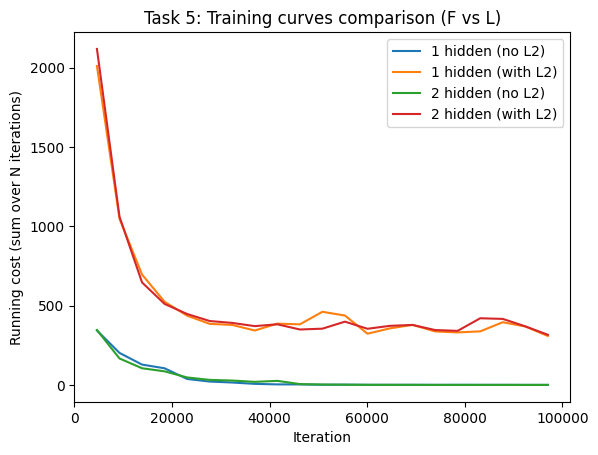


Best by validation: 1 hidden (no L2) layers= [784, 128, 1] lam= 0.0 val= 0.9878787878787879 test= 0.9929292929292929


In [179]:
def run_and_record(name, layers, alpha, lam):
    params, hist = fit_deep_sgd(
        X_train_s, y_train,
        layers=layers,
        alpha=alpha,
        lam=lam,
        max_iterations=100000,
        threshold=1e-4,
        N=len(X_train_s),
        seed=0,
        debug_every_N=False
    )

    ytr = predict_class_deep(X_train_s, params)
    yva = predict_class_deep(X_val_s, params)
    yte = predict_class_deep(X_test_s, params)

    tr = accuracy(y_train, ytr)
    va = accuracy(y_val, yva)
    te = accuracy(y_test, yte)

    return {"name": name, "layers": layers, "alpha": alpha, "lam": lam,
            "train": tr, "val": va, "test": te, "hist": hist, "params": params}

experiments = []
experiments.append(run_and_record("1 hidden (no L2)",   [784,128,1],      alpha=0.1, lam=0.0))
experiments.append(run_and_record("1 hidden (with L2)", [784,128,1],      alpha=0.1, lam=0.001))
experiments.append(run_and_record("2 hidden (no L2)",   [784,128,64,1],   alpha=0.1, lam=0.0))
experiments.append(run_and_record("2 hidden (with L2)", [784,128,64,1],   alpha=0.1, lam=0.001))

# Print table
print("-"*90)
print(f"{'Model':<20} {'Layers':<20} {'lam':>8} {'Train':>8} {'Val':>8} {'Test':>8}")
print("-"*90)
for e in experiments:
    print(f"{e['name']:<20} {str(e['layers']):<20} {e['lam']:>8.4f} {e['train']:>8.4f} {e['val']:>8.4f} {e['test']:>8.4f}")
print("-"*90)

# Plot training curves (running cost)
plt.figure()
for e in experiments:
    iters = [h[0] for h in e["hist"]]
    Jrun  = [h[1] for h in e["hist"]]
    plt.plot(iters, Jrun, label=e["name"])
plt.xlabel("Iteration")
plt.ylabel("Running cost (sum over N iterations)")
plt.title("Task 5: Training curves comparison (F vs L)")
plt.legend()
plt.show()

# Best by validation
best = max(experiments, key=lambda d: d["val"])
print("\nBest by validation:", best["name"], "layers=", best["layers"], "lam=", best["lam"], "val=", best["val"], "test=", best["test"])


- Best model is 1 hidden layer with no L2, because it has the highest validation accuracy (0.9879) and best test accuracy (0.9929).
- Adding another hidden layer doesn’t improve validation/test, it actually drops slightly so extra depth is not helping much for this simple binary task.
- Adding L2 regularization reduces training accuracy and also slightly reduces validation/test accuracy here, meaning the original model was already generalising well and didn’t really need extra regularization.

Training Curve:
- The no-L2 models (blue and green) drop their cost very quickly and reach almost zero, meaning they can fit the training data extremely well.
- The with-L2 models (orange and red) stay at a higher cost and don’t go near zero, that’s expected because L2 intentionally restricts the weights, so the model is not allowed to fit too perfectly.
- Overall, the curves show that training is stable (no explosion/divergence). The remaining bumps are normal SGD noise because the model updates using random samples.

In [191]:

best = max(experiments, key=lambda d: d["val"])
best_params = best["params"]

y_test_pred = predict_class_deep(X_test_s, best_params).reshape(-1)

TN = np.sum((y_test == 0) & (y_test_pred == 0))
FP = np.sum((y_test == 0) & (y_test_pred == 1))
FN = np.sum((y_test == 1) & (y_test_pred == 0))
TP = np.sum((y_test == 1) & (y_test_pred == 1))

print("Best model:", best["name"])
print("Layers:", best["layers"], "lam:", best["lam"])
print("Train/Val/Test:", best["train"], best["val"], best["test"])

Best model: 1 hidden (no L2)
Layers: [784, 128, 1] lam: 0.0
Train/Val/Test: 1.0 0.9878787878787879 0.9929292929292929


C:\Users\PS3\AppData\Local\Temp\ipykernel_14448\3500915864.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


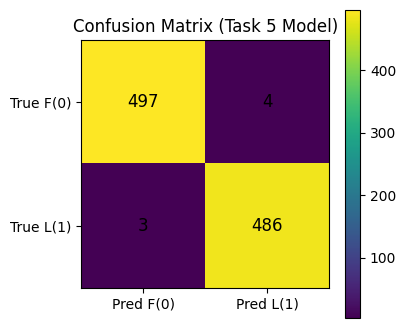

In [181]:
import matplotlib.pyplot as plt
import numpy as np

cm = np.array([[TN, FP],
               [FN, TP]])

plt.figure(figsize=(4,4))
plt.imshow(cm)
plt.xticks([0,1], ["Pred F(0)", "Pred L(1)"])
plt.yticks([0,1], ["True F(0)", "True L(1)"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center", fontsize=12)

plt.title("Confusion Matrix (Task 5 Model)")
plt.colorbar()
plt.show()


### CONCLUSION

I successfully extended my network to support an arbitrary number of layers and added L2 regularization (weight decay) as a method to reduce overfitting. I tested deep and shallow configurations on the Task 4 dataset (F vs L) and compared 1 hidden vs 2 hidden layers, and with vs without L2. The results show that a single hidden layer without L2 performs best, because this dataset is already highly separable and the simpler model generalises well. Adding more layers increases complexity without improving accuracy, and adding L2 slightly reduces performance because it constrains the model more than necessary for this task.